In [4]:
import pandas as pd
import numpy as np
import pysam
import os
import pickle
import configparser
import time
import concurrent.futures
import importlib

from scipy.interpolate import interp1d
from scipy.spatial.distance import jensenshannon
import statsmodels.api as sm
from scipy.stats import mstats
# import ruptures as rpt
import matplotlib.pyplot as plt
from scipy.stats import chi2, f, median_abs_deviation, norm, t
from scipy.spatial import distance
# from pingouin import multivariate_normality
import scipy.stats as st
import scipy.stats as stats
import distfit
from numpy.linalg import pinv, LinAlgError
from scipy.stats.mstats import rankdata
from scipy.stats import norm
from sklearn.utils import shuffle
from scipy.special import gammaln, jv

from read_counter import ReadCounter
from cbs import CBSSegmenter
import wbs

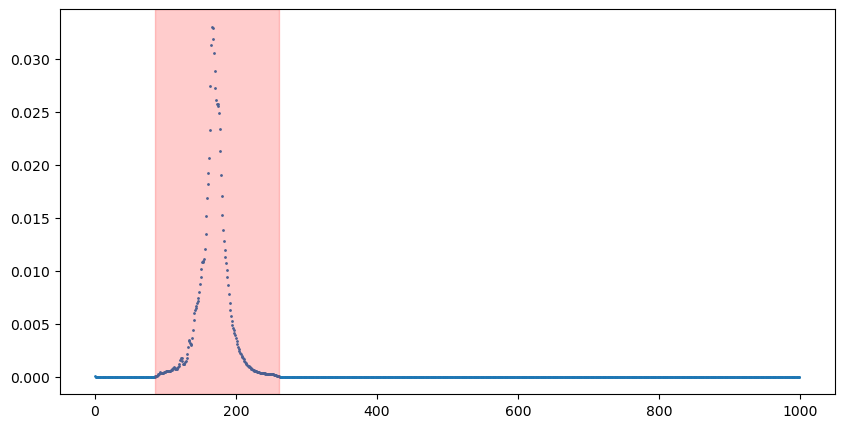

In [5]:
def get_peaks(arr):
    sign_change = np.diff((arr[1:] > 0).astype(int))
    indices = np.where(sign_change != 0)[0] + 1
    if arr[1:][0] > 0:
        indices = np.concatenate(([0], indices))
    if arr[1:][-1] > 0:
        indices = np.concatenate((indices, [len(arr[1:])]))
    return indices.reshape(-1, 2)


config = configparser.ConfigParser()
config.read('config.local.ini')
read_counter = ReadCounter(config=config)
regions = read_counter.read_regions()

with open('pon/median_coverage.pkl', 'rb') as f:
    pon = pd.read_pickle(f)
pon.reset_index(inplace=True)
pon = pon[['chrom', 'start', 'end', 'median']]
# get the median column to regions
regions = regions.merge(pon, on=['chrom', 'start', 'end'])

regions['log2_corrected'] = regions['log2'] - regions['median']
del pon


with open('test/luad34.fragment_length_freq.pkl', 'rb') as f:
    all_fragment_length_freq = pickle.load(f)
fig = plt.figure(figsize=(10, 5))
plt.scatter(range(len(all_fragment_length_freq)), all_fragment_length_freq, s=1)
for i, peak in enumerate(get_peaks(all_fragment_length_freq)):
    plt.axvspan(peak[0], peak[1], color='red', alpha=0.2)
    regions[f'peak_{i}'] = regions.loc[:, (peak[0]+1):peak[1]].apply(lambda x: jensenshannon(x, all_fragment_length_freq[peak[0]:peak[1]]), axis=1)
plt.show()
pd.to_pickle(regions, 'test/luad34.regions.entropies.pkl')

In [ ]:
importlib.reload(wbs)
from wbs import WBS

def plot(result, arm, title, orig_df):

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(orig_df.iloc[:, 1], orig_df.loc[:,'log2_corrected'], s=1, c='blue')
    print('Number of breakpoints: ', len(result))
    for bkps, cpt in result.items():
        plt.axvline(x=orig_df.iloc[:, 1].values[cpt.e], color='red', linewidth=1)
        plt.hlines(y=cpt.median, xmin=orig_df.iloc[:, 1].values[cpt.s], xmax=orig_df.iloc[:, 1].values[cpt.e], colors='black', linewidth=5)
        # plt.hlines(y=bkps[3], xmin=orig_df.iloc[:, 1].values[first], xmax=orig_df.iloc[:, 1].values[bkps], colors='black', linewidth=5)
    plt.title(title)
    plt.ylim(-0.5, 0.5)
    plt.show()

    return result


def process_group(arm_df_tuple):
    arm, df = arm_df_tuple
    if arm[0] == '21p': 
        return None
    tp1 = time.time()
    data = df[['log2_corrected', 'peak_0']].values
    print(f'arm: {arm}')
    wbs = WBS(data, zeros_path='test/zeros.csv')
    wbs.wbs_mulcusum()
    wbs.changepoint()
    tp2 = time.time()
    # print(f'time: {tp2 - tp1}')
    # plot(wbs.changepoints, arm, f'{arm}', df)
    return (arm, wbs.changepoints)

wbs_results = dict()
with concurrent.futures.ProcessPoolExecutor() as executor:
    for result in executor.map(process_group, regions.groupby(['arm'])):
        if result is not None:
            arm, changepoints = result
            wbs_results[arm[0]] = changepoints

medians = []
for arm, points in wbs_results.items():
    if arm not in ['19p', '19q']:
        for point in points.items():
            medians.append(point[1].median)
medians = np.array(sorted(medians))

In [14]:
import pymc as pm
import arviz as az
# import pymc.sampling.jax

# data = regions['log2_corrected'].sample(10000).values
data = medians

Kclonal = 6
Ksubclonal = 3
K = Kclonal * Ksubclonal

alpha = np.ones(K) * 3
beta = np.ones(K) * (1 / (np.square(np.std(data)) / np.sqrt(K)))

with pm.Model() as model:
    n = pm.Beta('n', alpha=1, beta=1)
    s = pm.Beta('s', alpha=1, beta=1)
    phi = pm.Gamma('phi', alpha=1, beta=1)

    w = pm.Dirichlet('w', a=np.ones(K))

    mu = pm.Deterministic('mu', pm.math.log(2*n + (2*s*(1-n) + (1-s)*(1-n)*np.repeat(np.arange(0, Kclonal), Ksubclonal))/(2*n + (1-n)*phi)))
    lambda_ = pm.Gamma('lambda', alpha=alpha, beta=beta, shape=K)
    nu = 2.1

    obs = pm.Mixture('obs', w, pm.StudentT.dist(mu=mu, lam=lambda_, nu=nu, shape=K), observed=data)


    trace = pm.sample(1000, tune=1000, cores=16, chains=4, target_accept=0.95, return_inferencedata=True)

az.plot_trace(trace, var_names=['mu', 'n', 's', 'phi', 'lambda'])
az.summary(trace, var_names=['mu', 'n', 's', 'phi', 'lambda'])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 16 jobs)
NUTS: [n, s, phi, w, lambda]


[distfit] >INFO> fit
[distfit] >INFO> transform


-0.03567534292378542 0.06203915751071663


[distfit] >INFO> [dweibull  ] [5.02 sec] [RSS: 83.3785] [loc=0.007 scale=0.014]
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 62.4693] [loc=0.007 scale=0.017]
[distfit] >INFO> [t         ] [6.58 sec] [RSS: 57.275] [loc=0.007 scale=0.016]
[distfit] >INFO> [genextreme] [16.1 sec] [RSS: 106.723] [loc=0.000 scale=0.016]
[distfit] >INFO> [lognorm   ] [8.46 sec] [RSS: 75.9669] [loc=-0.244 scale=0.250]
[distfit] >INFO> [beta      ] [18.9 sec] [RSS: 76.1607] [loc=-0.162 scale=35750.089]
[distfit] >INFO> [loggamma  ] [5.96 sec] [RSS: 64.0232] [loc=-3.309 scale=0.490]
[distfit] >INFO> [gamma     ] [3.76 sec] [RSS: 76.0979] [loc=-0.162 scale=0.002]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: T(loc:0.006666, scale:0.015782)


(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nt(df=22.1677, loc=0.00666611, scale=0.0157818)'}, xlabel='Values', ylabel='Frequency'>)

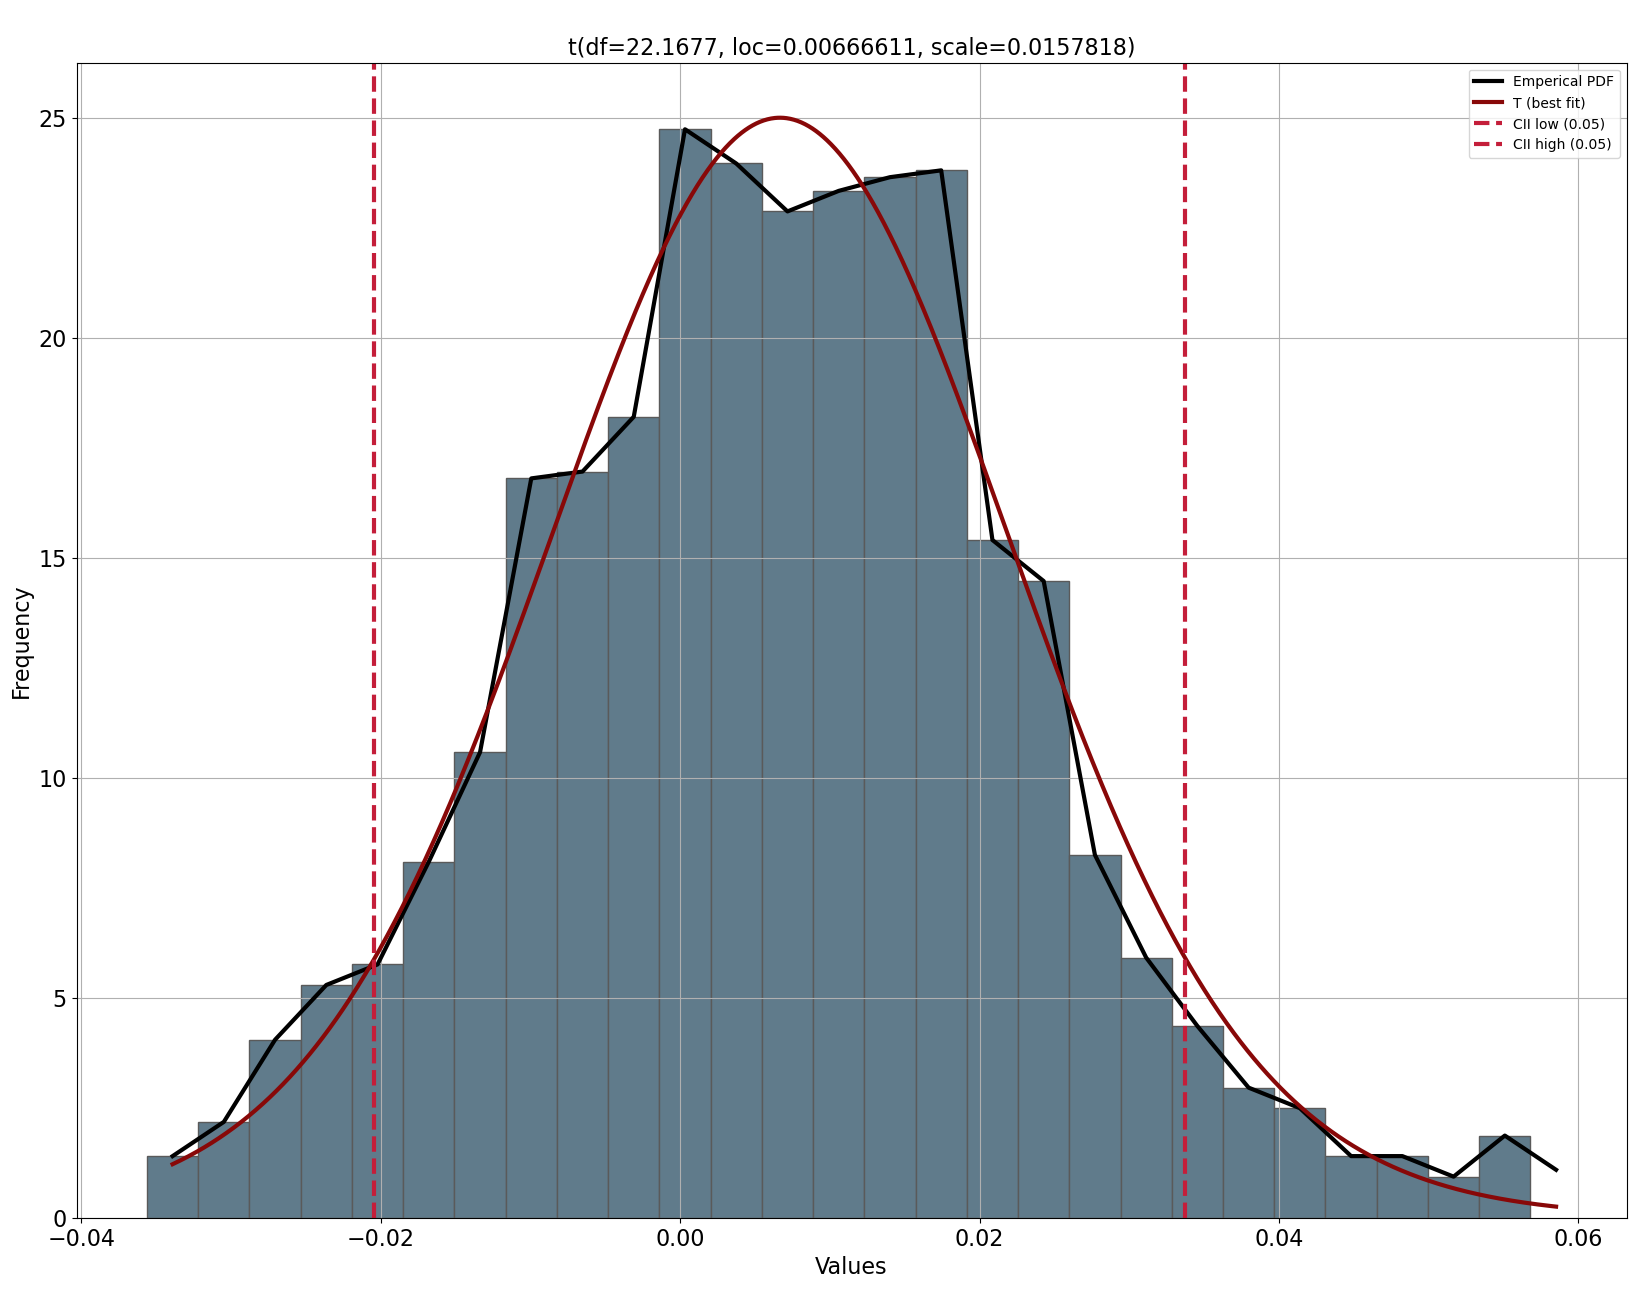

In [26]:
medians = []
for arm, points in wbs_results.items():
    if arm not in ['19p', '19q']:
        for point in points.items():
            medians.append(point[1].median)
medians = np.array(sorted(medians))
lower_q, upper_q = np.percentile(medians, [1, 99])
print(lower_q, upper_q)
medians = medians[(medians > lower_q) & (medians < upper_q)]   
f = distfit.distfit(distr=['dweibull', 'norm', 't', 'genextreme', 'lognorm', 'beta', 'loggamma', 'gamma'])
f.fit_transform(medians)
f.plot()

[distfit] >INFO> Ploting Summary.


(<Figure size 2000x1000 with 1 Axes>,
 <Axes: title={'center': 'T (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

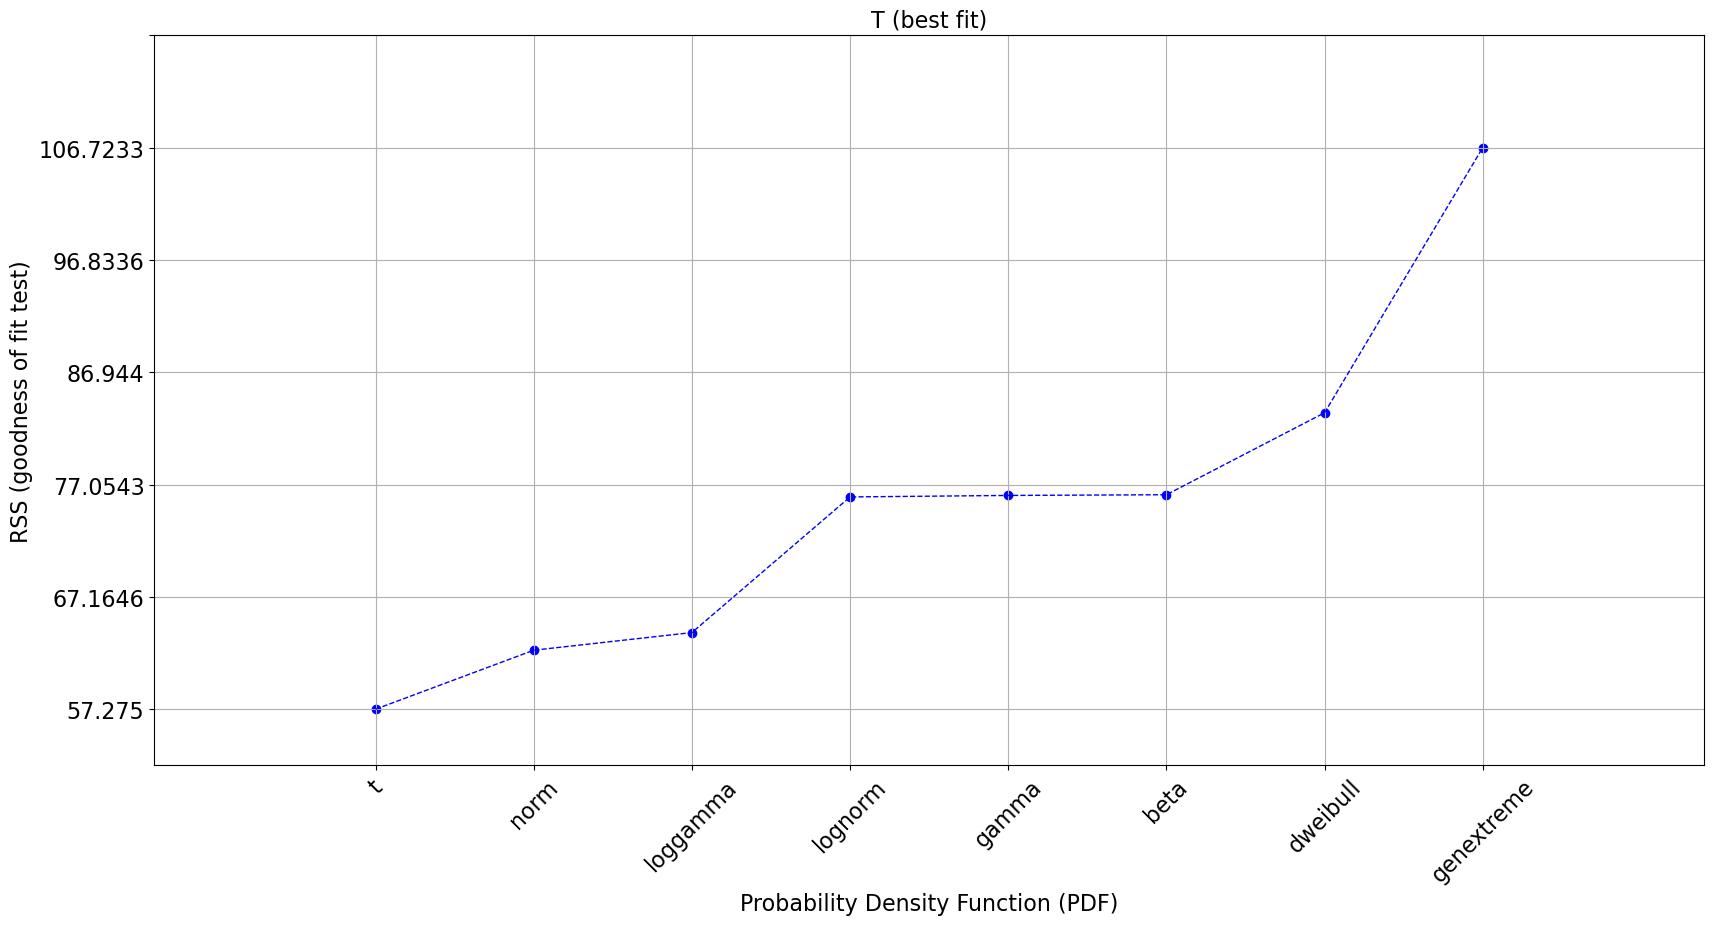

In [27]:
f.plot_summary()

In [20]:
import pymc3 as pm
import theano.tensor as tt
n_components = 5
model = pm.Model()

with model:
    # Prior for each component's weight
    w = pm.Dirichlet('w', a=np.ones(n_components), shape=n_components)

    # Priors for unknown model parameters
    n = pm.Beta('n', alpha=3, beta=3)
    s = pm.Beta('s', alpha=3, beta=3)
    phi = pm.Gamma('phi', alpha=3, beta=3)

    # Define custom function for the means
    mu = tt.log(2*n + 2*s*(1-n) + (1-s)*(1-n)*tt.arange(n_components) / (2*n + (1-n)*phi))

    # Mixture model
    obs = pm.NormalMixture('obs', w, mu, sd=0.1, observed=segments_arr)
    # Sample from the posterior

with model:
    trace = pm.sample(1000)


/home/hadas/miniconda3/envs/alt/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, s, n, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [13]:
with model:
    map_estimate = pm.find_MAP()
map_estimate

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'w_stickbreaking__': array([0.]), 'n': array(0.), 's': array(0.), 'phi': array(0.)}

Initial evaluation results:
w_stickbreaking__   -0.69
n                   -0.92
s                   -0.92
phi                 -0.92
obs                   NaN
Name: Log-probability of test_point, dtype: float64

Number of breakpoints:  66


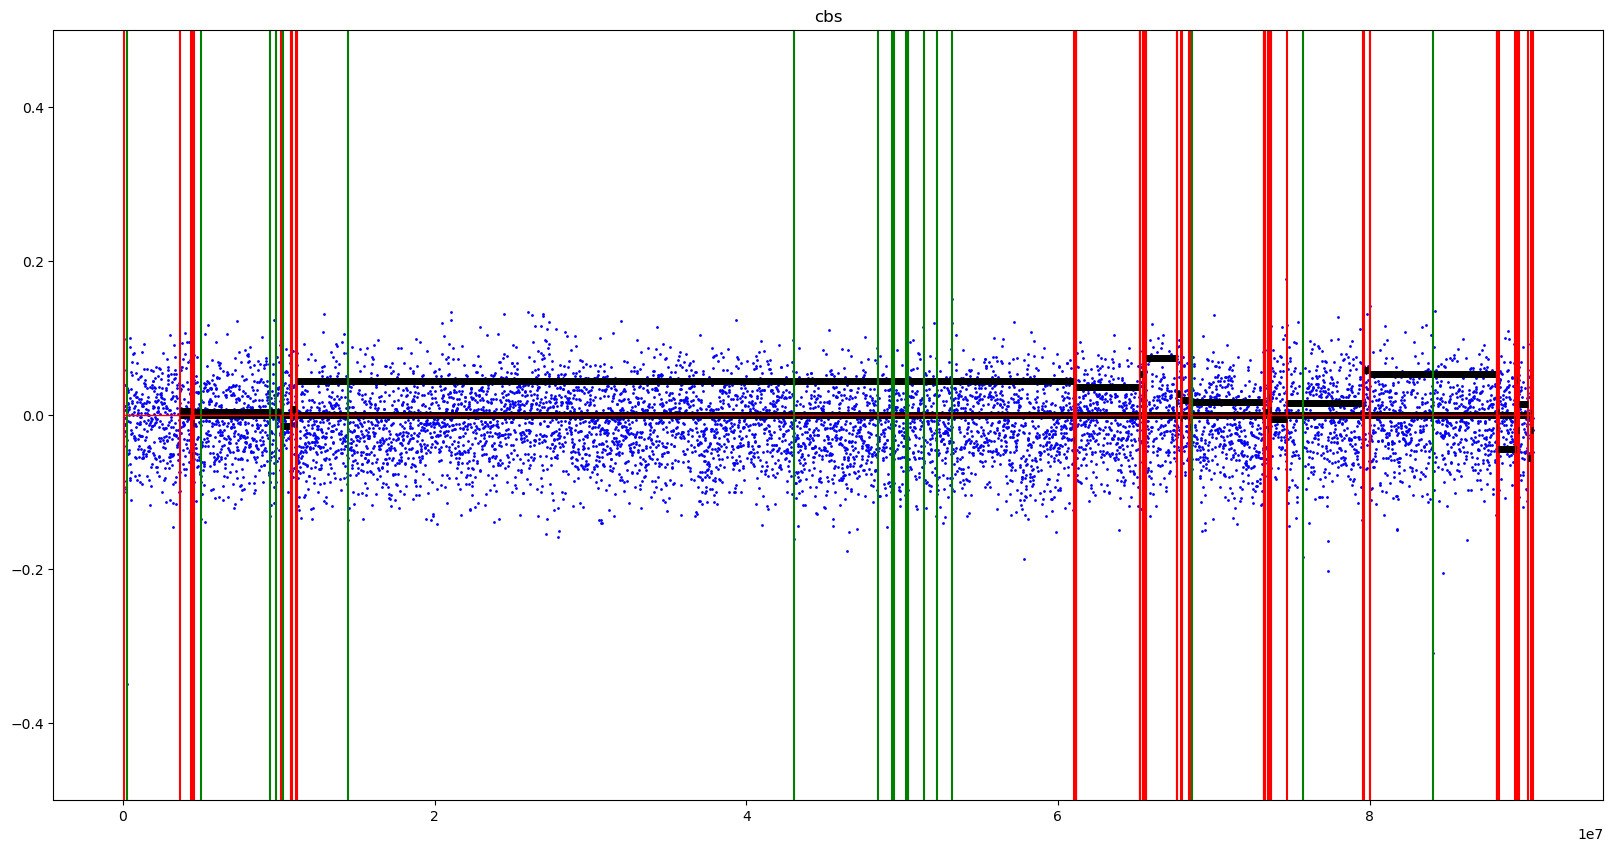

[(0, 344, 0.04902109091825377, -0.004774234639975963),
 (344, 404, 0.010956156615468518, 0.0005698548415349579),
 (405, 409, 0.00293775118340847, 0.0053953501361311),
 (409, 411, 0.0007960696796008702, -0.01877525503950346),
 (411, 417, 0.003003484272696305, 0.013330617462634965),
 (417, 420, 0.014255620317134628, -0.05144380942218596),
 (420, 959, 0.016735789561691965, -0.010019926898573544),
 (959, 1015, 0.011960737062063628, 0.004536675710082101),
 (1016, 1018, 0.0015736336860519486, -0.014256836561351505),
 (1018, 1021, 0.00010179684263752421, 0.00581478552399646),
 (1021, 1049, 0.006882061494837065, -0.010463004948425968),
 (1049, 1051, 4.934400324808491e-05, 0.007503043814333907),
 (1051, 1055, 0.002857626583340819, -0.0006290030256764188),
 (1056, 5737, 0.1633074173839927, -0.011595521225153671),
 (5737, 5742, 0.00904610651803309, 0.0439452607675893),
 (5742, 5745, 0.003860895159706986, -0.032946170931316396),
 (5745, 5747, 2.8860421284121718e-05, 0.011749149766846507),
 (5747, 

In [18]:
def plot(result, arm, title):

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(orig_df.iloc[:, 1], orig_df.loc[:,'log2_corrected'], s=1, c='blue')
    print('Number of breakpoints: ', len(result))
    first = 0
    for bkps in result:
        plt.axvline(x=orig_df.iloc[:, 1].values[bkps[0]], c='red')
        plt.hlines(y=bkps[3], xmin=orig_df.iloc[:, 1].values[first], xmax=orig_df.iloc[:, 1].values[bkps[0]], colors='black', linewidth=5)
        # print(f'{orig_df.iloc[:, 1].values[first]}-{orig_df.iloc[:, 1].values[bkps-1]} {np.median(orig[first:bkps])} {np.mean(orig[first:bkps])}')
        # segments[(arm, orig_df.iloc[:, 1].values[first], orig_df.iloc[:, 1].values[bkps[0]-1])] = np.median(orig[first:bkps[0]])
        first = bkps[0] - 1
    for index,row in orig_df[orig_df['p_value'] < 0.1].iterrows():
        plt.axvline(row['start'], color='green', alpha=1)
    plt.hlines(y=0, xmin=orig_df.iloc[:, 1].values[0], xmax=orig_df.iloc[:, 1].values[-1], colors='red', linewidth=1)
    # plt.xlim(1.25e8, 1.5e8)
    plt.title(title)
    plt.ylim(-0.5, 0.5)
    plt.show()

    return result

arm = '3p'
orig_df = regions[regions['arm'] == arm].sort_values('start')
values = orig_df['log2_corrected'].values
labels = np.zeros_like(values)
segmenter = cbs.CBSSegmenter(1000, 1)
segments = segmenter.cbs_segment(values)
plot(segments, arm, 'cbs')
# plot(values, values, arm, "l1", 0.3, f'{arm} mahalanobis')

Number of breakpoints:  20


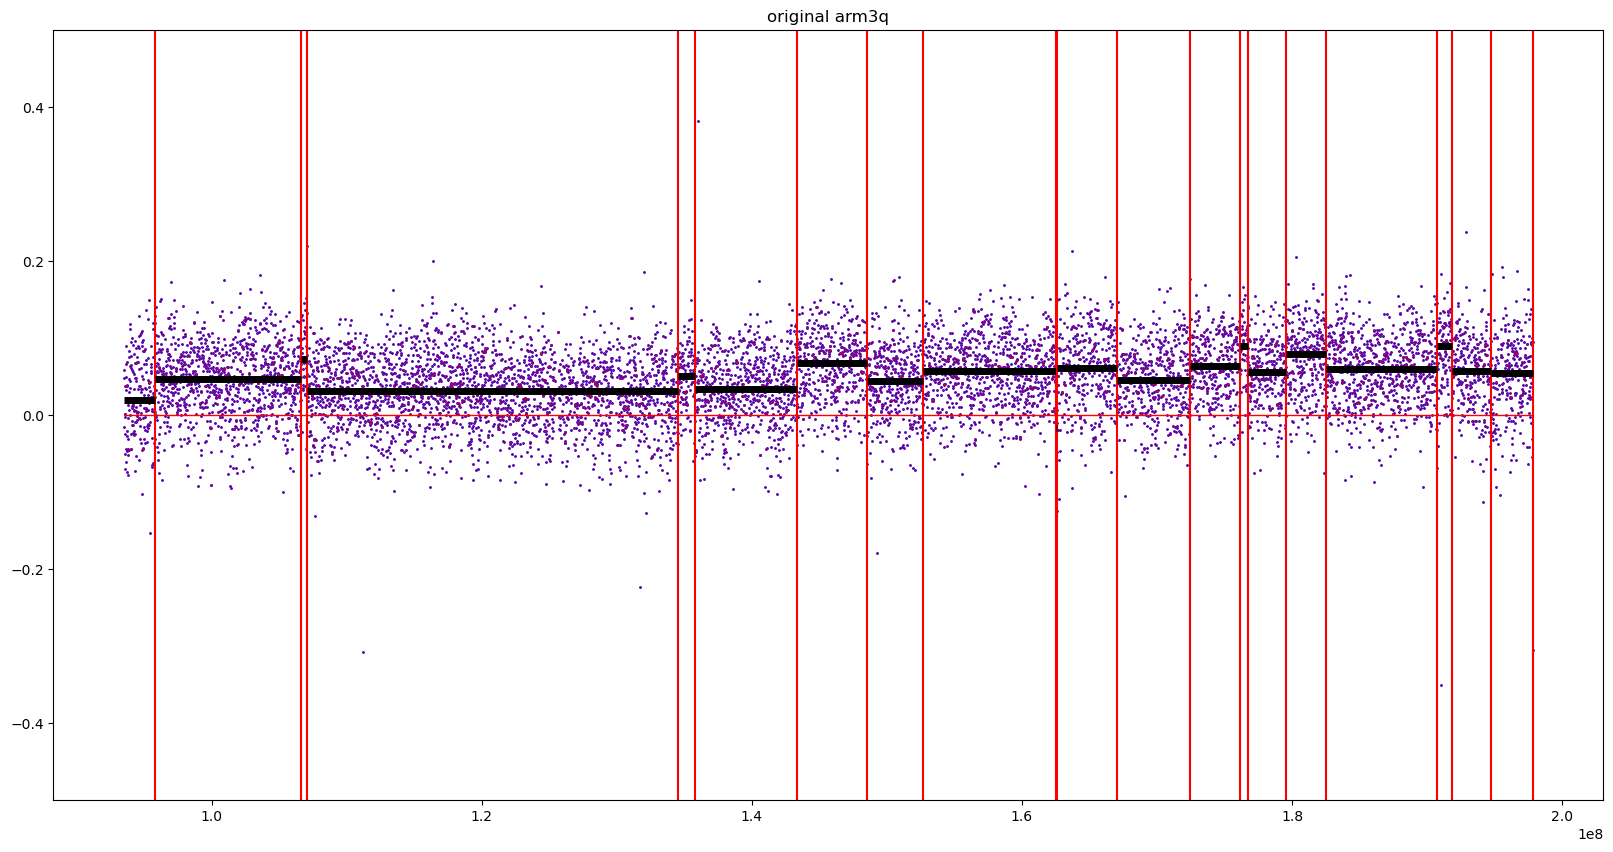

In [82]:
from scipy.stats import spearmanr

class CustomCost(rpt.base.BaseCost):
    def fit(self, signal):
        self.signal = signal
        return self

    def error(self, start, end):
        sub_orig = self.signal[start:end, 0]
        sub_peak = self.signal[start:end, 1]
        # Compute the Spearman correlation between the two signals
        correlation, _ = spearmanr(sub_orig, sub_peak)
        # Return negative correlation because we want to maximize correlation,
        # but the change point detection algorithm minimizes the cost function.
        return -correlation


def plot(signal, orig, peak, arm, model, pen, title):
    # Stack primary and auxiliary signals
    signal = np.column_stack([orig, peak])

    algo = rpt.Pelt(model=model).fit(signal)
    result = algo.predict(pen=pen)

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(orig_df.iloc[:, 1], orig, s=1, c='blue')
    # ax.scatter(orig_df.iloc[:, 1], peak, s=1, c='red')
    ax.scatter(orig_df.iloc[:, 1], signal[:, 0], s=0.1, c='red')
    print('Number of breakpoints: ', len(result))
    first = 0
    for bkps in result:
        plt.axvline(x=orig_df.iloc[:, 1].values[bkps-1], c='red')
        plt.hlines(y=np.median(orig[first:bkps]), xmin=orig_df.iloc[:, 1].values[first], xmax=orig_df.iloc[:, 1].values[bkps-1], colors='black', linewidth=5)
        # print(f'{orig_df.iloc[:, 1].values[first]}-{orig_df.iloc[:, 1].values[bkps-1]} {np.median(orig[first:bkps])} {np.mean(orig[first:bkps])}')
        segments[(arm, orig_df.iloc[:, 1].values[first], orig_df.iloc[:, 1].values[bkps-1])] = np.median(orig[first:bkps])
        first = bkps - 1
    plt.hlines(y=0, xmin=orig_df.iloc[:, 1].values[0], xmax=orig_df.iloc[:, 1].values[-1], colors='red', linewidth=1)
    plt.title(title)
    plt.ylim(-0.5, 0.5)
    plt.show()

    return result

segments = {}

# for arm in regions.arm.unique():
for arm in ['3q']:
    orig_df = regions[regions['arm'] == arm].sort_values('start')
    orig = orig_df['log2_corrected'].values.reshape(-1, 1)
    peak = orig_df['peak_0'].values.reshape(-1, 1)
    bkps = plot(orig, orig, peak, arm, "l1", 0.3, f"original arm{arm}")


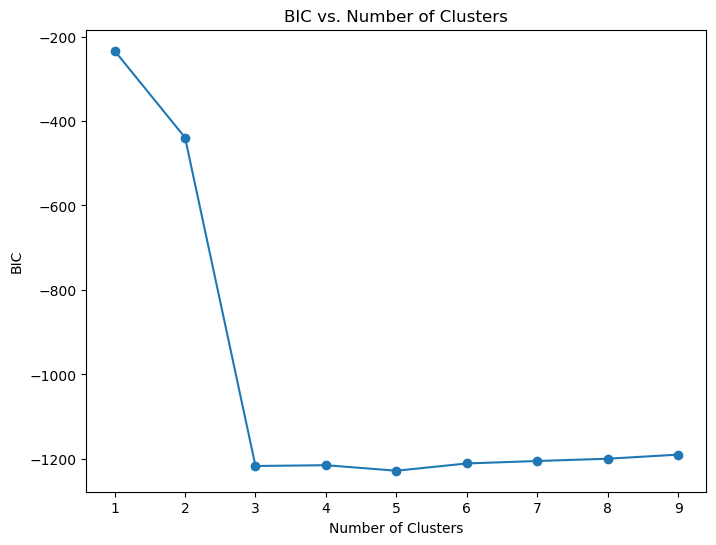

Optimal number of clusters:  5


/tmp/ipykernel_1826/2186974659.py:48: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X, y_gmm, s=40, cmap='viridis')


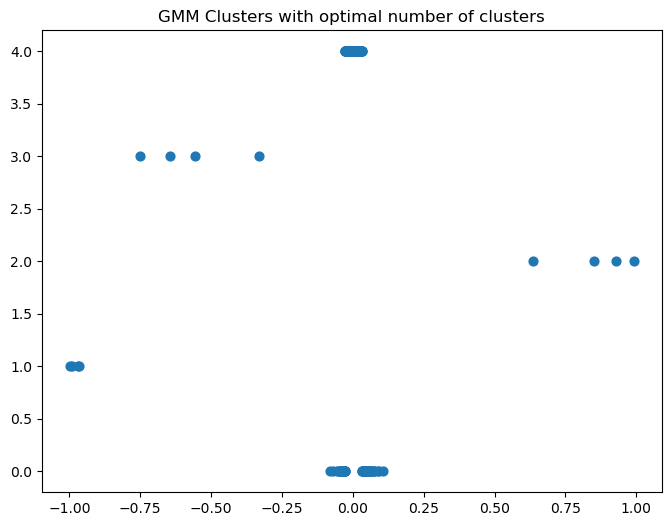

In [33]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic one-dimensional data
np.random.seed(0)
X = np.concatenate([np.random.normal(0, 1, 200), np.random.normal(5, 1, 200), np.random.normal(10, 1, 200)])
X = X.reshape(-1, 1) # Reshape because sklearn expects a 2D array
X = np.array([x for x in segments.values()]).reshape(-1, 1)
# Define the range of clusters to test
clusters = np.arange(1, 10)

# Initialize an empty list to store the BIC values for each cluster
bics = []

for cluster in clusters:
    # Fit a Gaussian Mixture Model with the current number of clusters
    gmm = GaussianMixture(n_components=cluster, random_state=42)
    gmm.fit(X)
    
    # Get the BIC for the current model
    bic = gmm.bic(X)
    
    # Append the BIC to our list
    bics.append(bic)

# Plot BIC vs number of clusters
plt.figure(figsize=(8,6))
plt.plot(clusters, bics, marker='o')
plt.title("BIC vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC")
plt.show()

# Determine the optimal number of clusters
optimal_clusters = clusters[np.argmin(bics)]
print("Optimal number of clusters: ", optimal_clusters)

# Fit a Gaussian Mixture Model with the optimal number of clusters
gmm_optimal = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm_optimal.fit(X)

# Predict the cluster for each data point
y_gmm = gmm_optimal.predict(X)

# Plot the clusters predicted by the GMM with optimal number of clusters
plt.figure(figsize=(8,6))
plt.scatter(X, y_gmm, s=40, cmap='viridis')
plt.title("GMM Clusters with optimal number of clusters")
plt.show()


In [81]:
import numpy as np
from scipy.stats import beta, gamma

def em_algorithm(log_copy_numbers, n_init, s_init, phi_init, max_iter=100):
    n = n_init
    s = s_init
    phi = phi_init

    for i in range(max_iter):
        # E-step: Estimate the expected value of the hidden variables given the observed data and current estimate of the parameters.
        # Without specific details about the model, this part is left out.

        # M-step: Maximize the expected log likelihood found on the E-step with respect to the parameters to update them.
        n = beta.mean(a=1, b=np.mean(log_copy_numbers)) # replace the parameters of the beta distribution as per your model
        s = beta.mean(a=1, b=np.mean(log_copy_numbers)) # replace the parameters of the beta distribution as per your model
        phi = gamma.mean(a=1, scale=np.mean(log_copy_numbers)) # replace the parameters of the gamma distribution as per your model

    return n, s, phi

# Usage:
log_copy_numbers = merged_df['log2_corrected'].values
n_init, s_init, phi_init = 0.5, 0.5, 2.0  # Initial values for n, s, and phi.
n, s, phi = em_algorithm(log_copy_numbers, n_init, s_init, phi_init)
print(n, s, phi)  # 0.5 0.5 2.0

0.9938967564541693 0.9938967564541693 0.006140721866931871


In [43]:
for y in set(y_gmm):
    print(f'cluster {y}: {X[y_gmm == y].shape}, {np.median(X[y_gmm == y])}')

cluster 0: (50, 1), 0.03905916738000226
cluster 1: (4, 1), -0.9805858491868094
cluster 2: (4, 1), 0.8896346117909522
cluster 3: (4, 1), -0.6021698419359724
cluster 4: (252, 1), 0.006717956189200497


In [70]:
import numpy as np
from scipy.optimize import curve_fit

# define the form of the function you are trying to fit
def func(x, n, s, phi):  # add x as a dummy variable
    return np.log2((2*n + 2*s*(1-n) + (1-s)*(1-n)*2)/(2*n+(1-n)*phi))

# your list of mu values
mu_values = X[y_gmm == 4].reshape(-1)  # replace with your list

# initial guess for n, s, phi
initial_guess = [0.98, 0.1, 2]

# since there's no x data in the usual sense, we use the indices of the mu_values array
indices = np.arange(mu_values.size)

# perform the curve fit
popt, pcov = curve_fit(func, indices, mu_values, p0=initial_guess, maxfev=10000)

print("n, s, phi = ", popt)

from scipy.optimize import leastsq

def residuals(params, x, y):
    n, s, phi = params
    theoretical = np.log2((2*n + 2*s*(1-n) + (1-s)*(1-n)*2)/(2*n+(1-n)*phi))
    return y - theoretical

indices = np.arange(mu_values.size)
result, _ = leastsq(residuals, initial_guess, args=(indices, mu_values))

print("n, s, c, phi = ", result)

from scipy.optimize import minimize

def objective(params):
    n, s, phi = params
    theoretical = np.log2((2*n + 2*s*(1-n) + (1-s)*(1-n)*c)/(2*n+(1-n)*phi))
    return np.sum((mu_values - theoretical)**2)

# initial guess for n, s, phi
initial_guess = [0.9, 0.5, 0.1]

# bounds
bounds = [(None, None),  # bounds for n
          (0, 1),        # bounds for s
          (0, 1)]        # bounds for phi

# solve for c = 2
c = 2
result2 = minimize(objective, initial_guess, bounds=bounds, method='SLSQP')

# solve for c = 3
c = 3
result3 = minimize(objective, initial_guess, bounds=bounds, method='SLSQP')

# choose the solution with the lowest objective function value
if result2.fun < result3.fun:
    best_result = result2
    c_best = 2
else:
    best_result = result3
    c_best = 3

print(f"Best solution is for c = {c_best} with n, s, phi = {best_result.x}, result2 = {result2.fun}, result3 = {result3.fun}")



n, s, phi =  [0.98034991 0.1        1.70375014]
n, s, c, phi =  [0.98034991 0.1        1.70375014]
Best solution is for c = 3 with n, s, phi = [0.9948116  0.94530525 0.92883086], result2 = 0.05439518225049256, result3 = 0.05439511573248822


/home/hadas/miniconda3/envs/alt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_1826/3106248176.py:38: RuntimeWarning: invalid value encountered in log2
  theoretical = np.log2((2*n + 2*s*(1-n) + (1-s)*(1-n)*c)/(2*n+(1-n)*phi))


<Axes: title={'center': 'Peak 0 corrected reads by GC content'}, xlabel='start', ylabel='peak_0'>

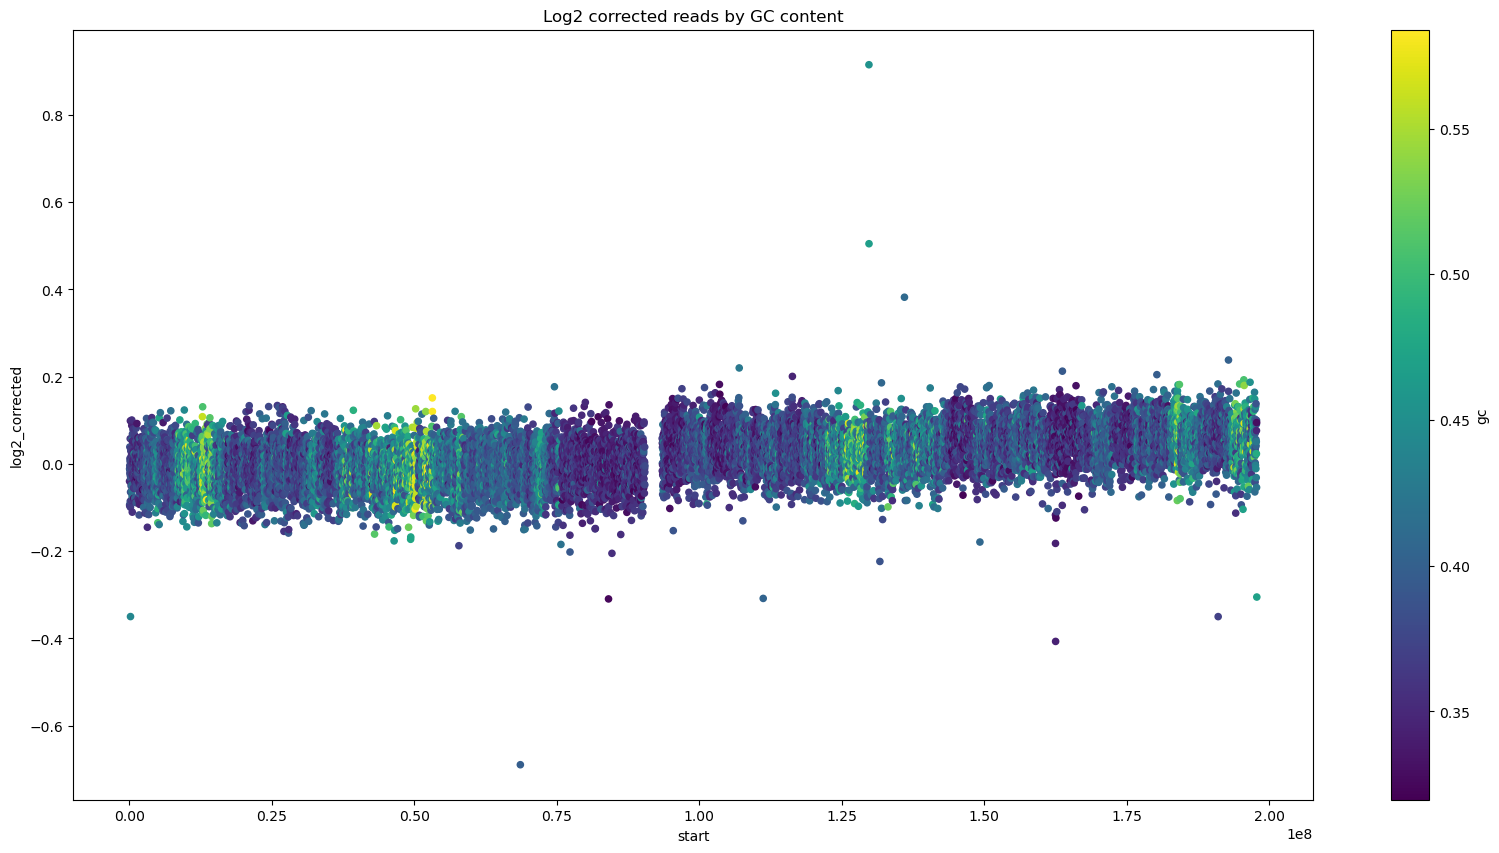

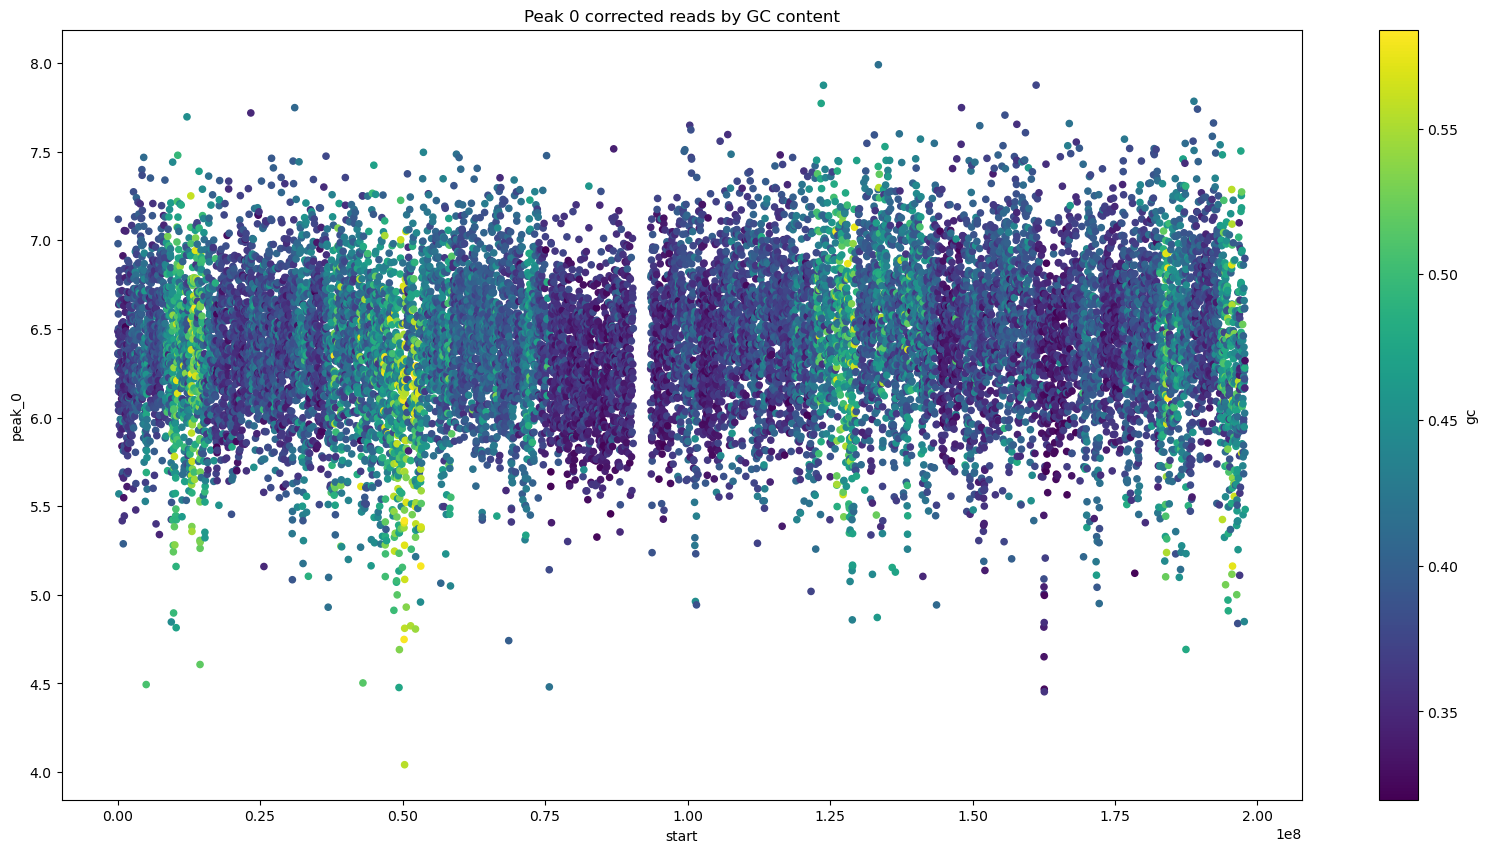

In [39]:
# regions[regions['chrom'] == '3'].plot.scatter(x='start', y='reads', c='gc', colormap='viridis', figsize=(20,10), title='Reads by GC content')
# regions[regions['chrom'] == '3'].plot.scatter(x='start', y='gc_corrected', c='gc', colormap='viridis', figsize=(20,10), title='GC corrected reads by GC content')
# regions[regions['chrom'] == '3'].plot.scatter(x='start', y='map_corrected', c='gc', colormap='viridis', figsize=(20,10), title='MAP corrected reads by GC content')
# regions[regions['chrom'] == '3'].plot.scatter(x='start', y='log2', c='gc', colormap='viridis', figsize=(20,10), title='Log2 corrected reads by GC content')
regions[regions['chrom'] == '3'].plot.scatter(x='start', y='log2_corrected', c='gc', colormap='viridis', figsize=(20,10), title='Log2 corrected reads by GC content')
regions[regions['chrom'] == '3'].plot.scatter(x='start', y='peak_0', c='gc', colormap='viridis', figsize=(20,10), title='Peak 0 corrected reads by GC content')

In [10]:
import importlib
import cbs
importlib.reload(cbs)
import matplotlib.pyplot as plt
import numpy as np

def plot_segments(segments, values, arm, bkps = None):
    plt.figure(figsize=(10, 8))
    for s in segments:
        plt.scatter(range(s[0], s[1]), values[s[0]:s[1]], s=1)
        plt.hlines(s[3], s[0], s[1], color='r')
    if bkps is not None:
        for b in bkps:
            plt.axvline(x=b, color='r', linestyle='--')
    plt.hlines(0, 0, len(values), color='k')
    plt.title(f'Chromosome {arm}')
    plt.ylim(-0.2, 0.2)
    plt.show()

np.random.seed(0)
values = np.random.randn(1000)#.cumsum() #+ 50. * np.log1p(np.arange(1000))
labels = np.zeros_like(values)
labels[300:600] = 1
labels[600:] = 2
arm = '19q'

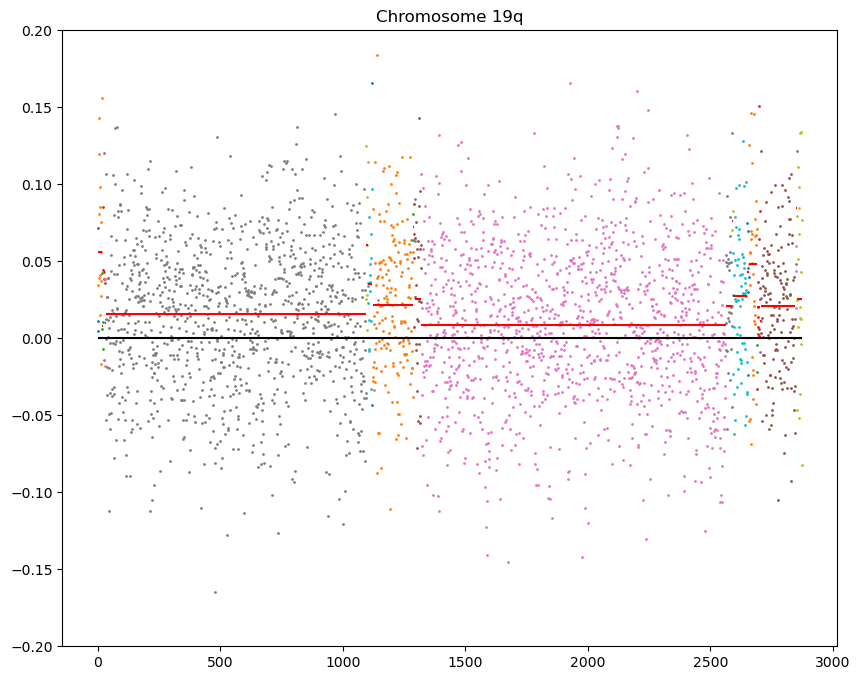

In [11]:
orig_df = regions[regions['arm'] == arm].sort_values('start')
values = orig_df['log2_corrected'].values
labels = np.zeros_like(values)
segmenter = cbs.CBSSegmenter(1000, 10)
segments = segmenter.cbs_segment(values)
plot_segments(segments, values, arm)


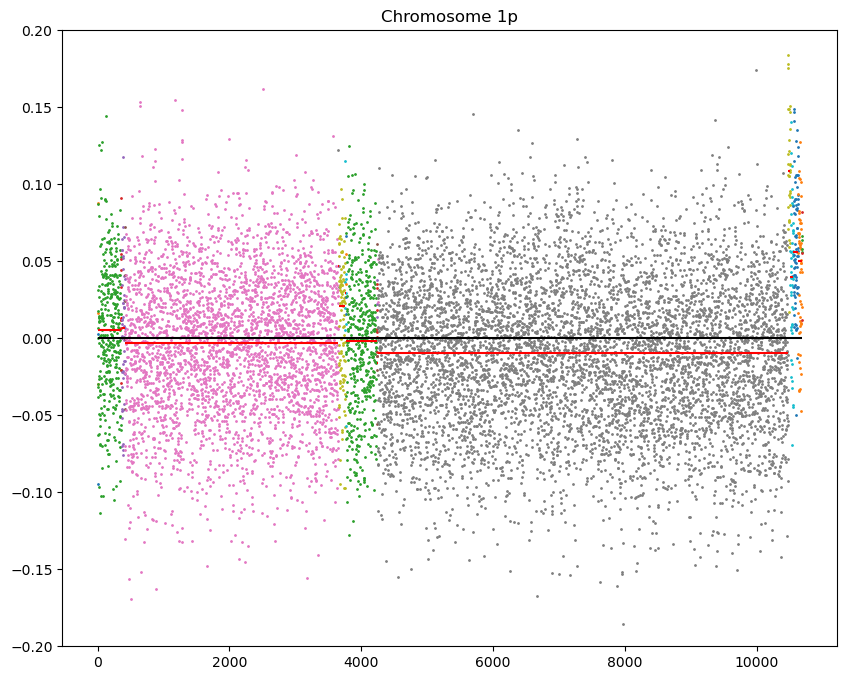

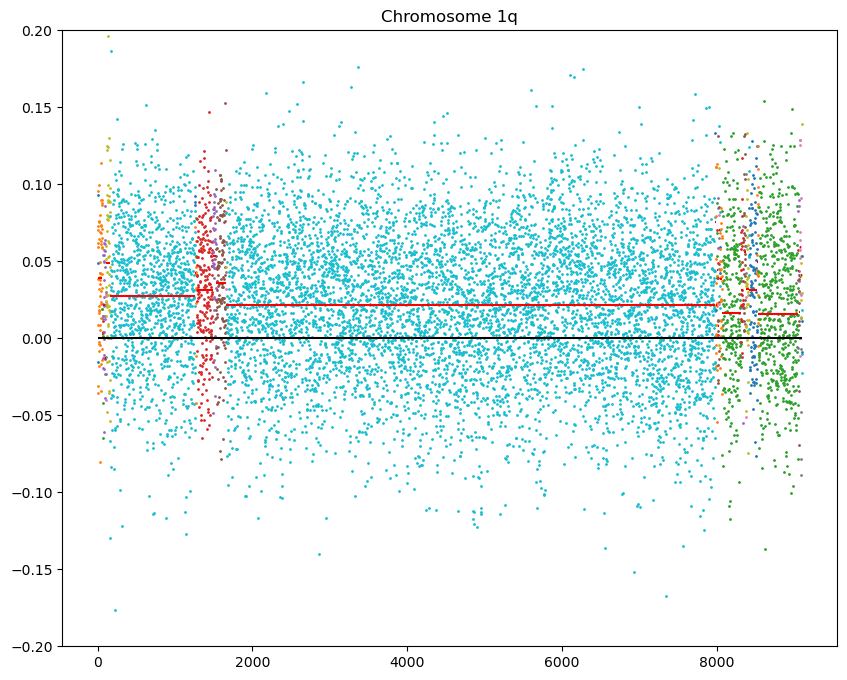

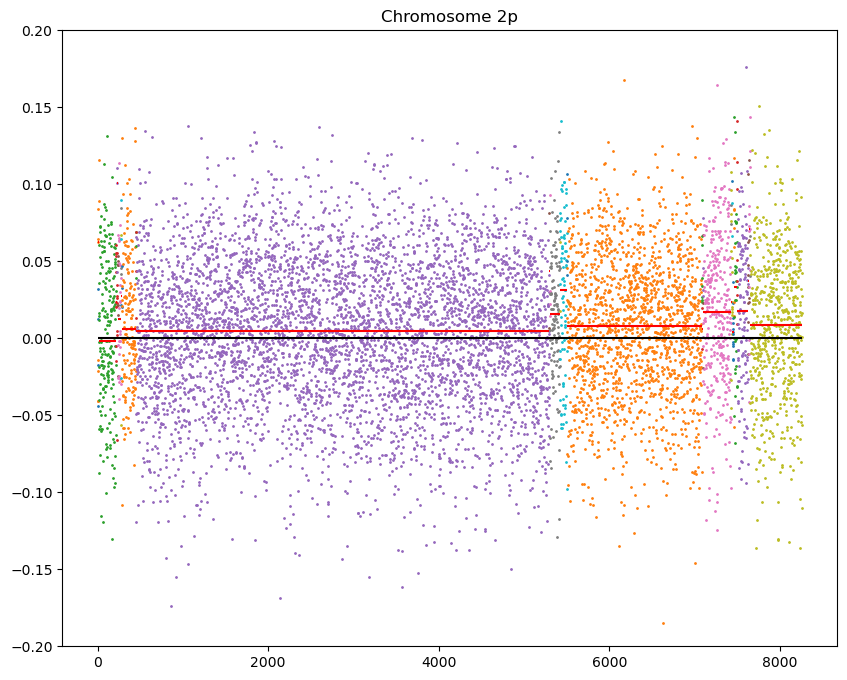

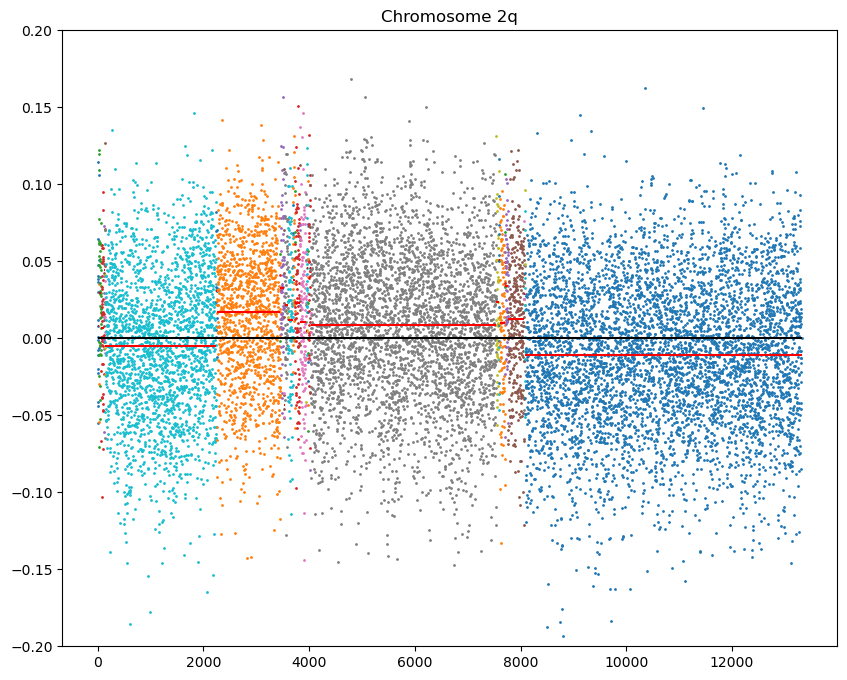

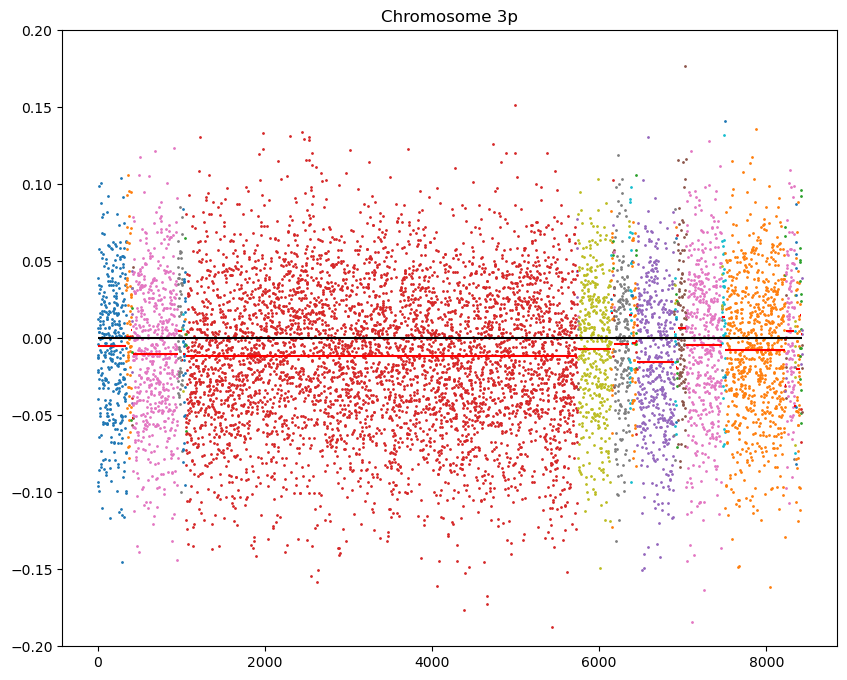

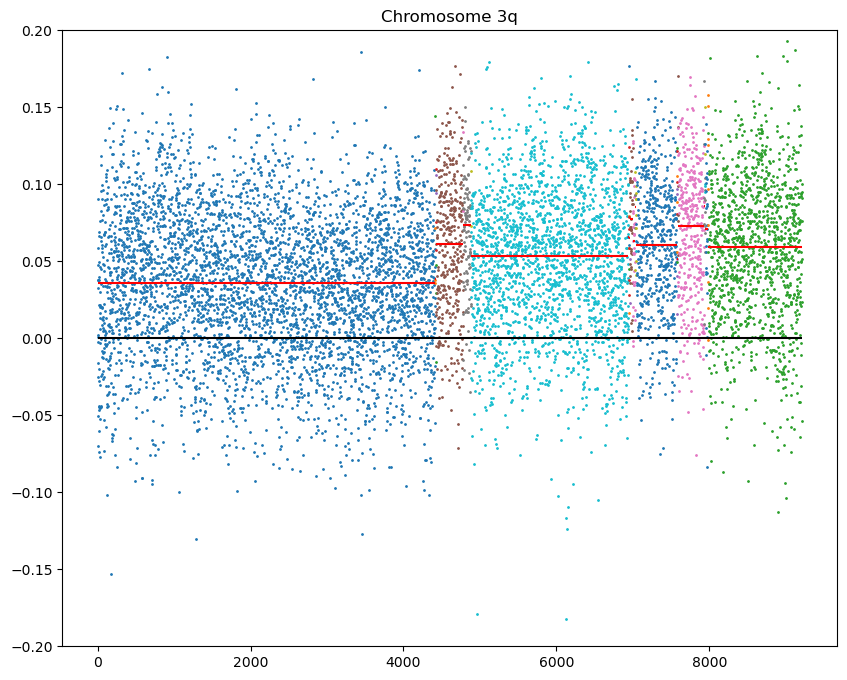

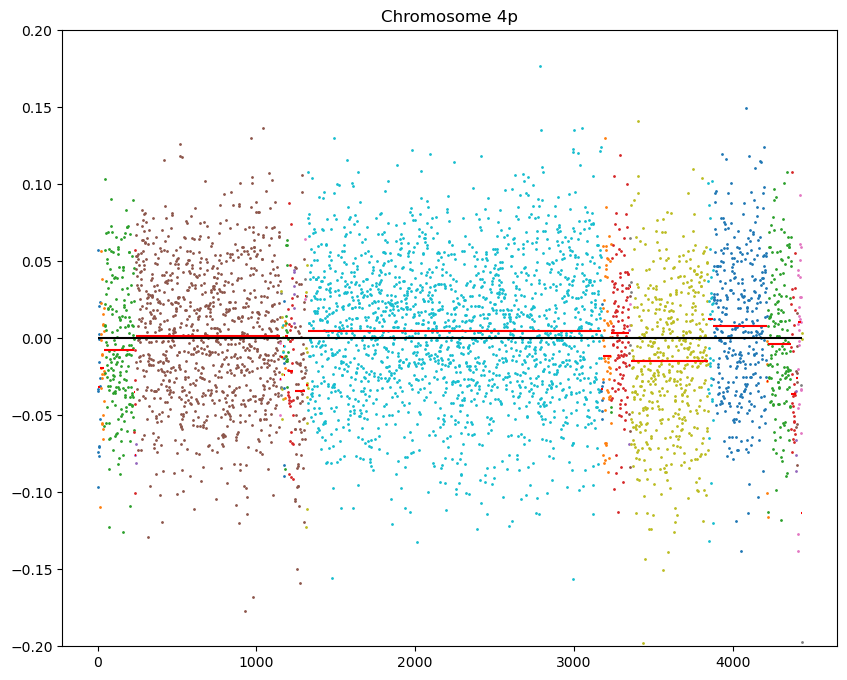

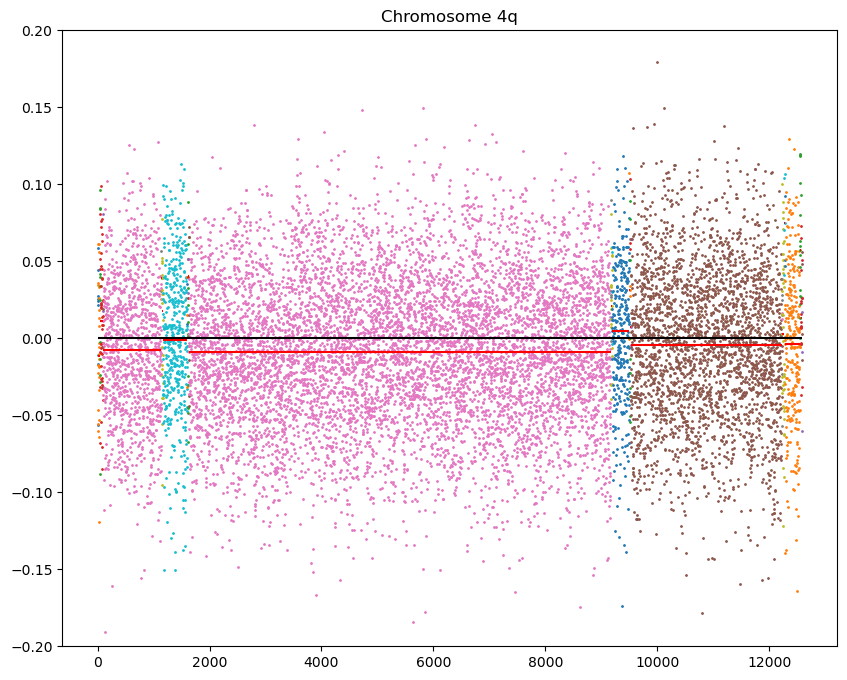

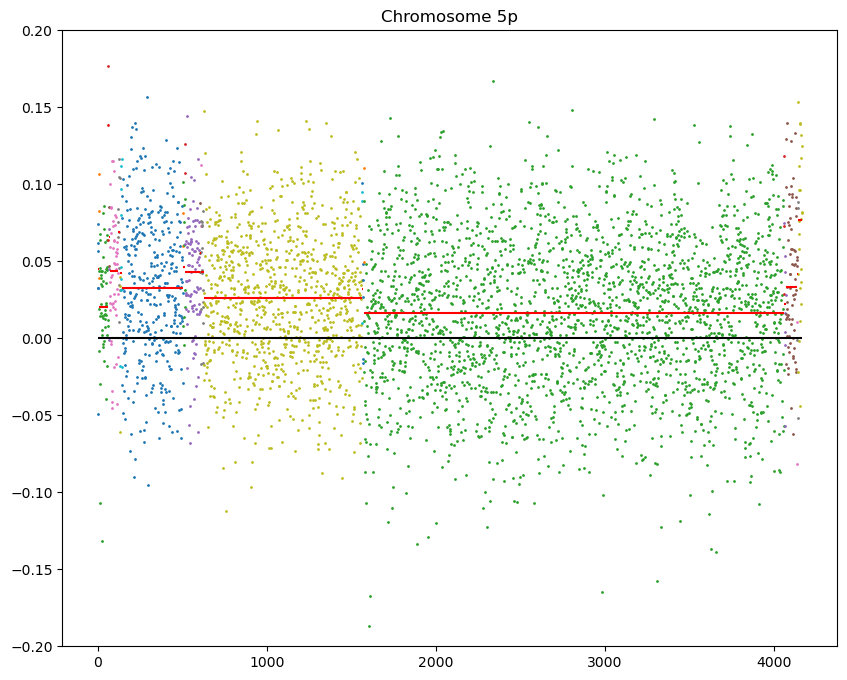

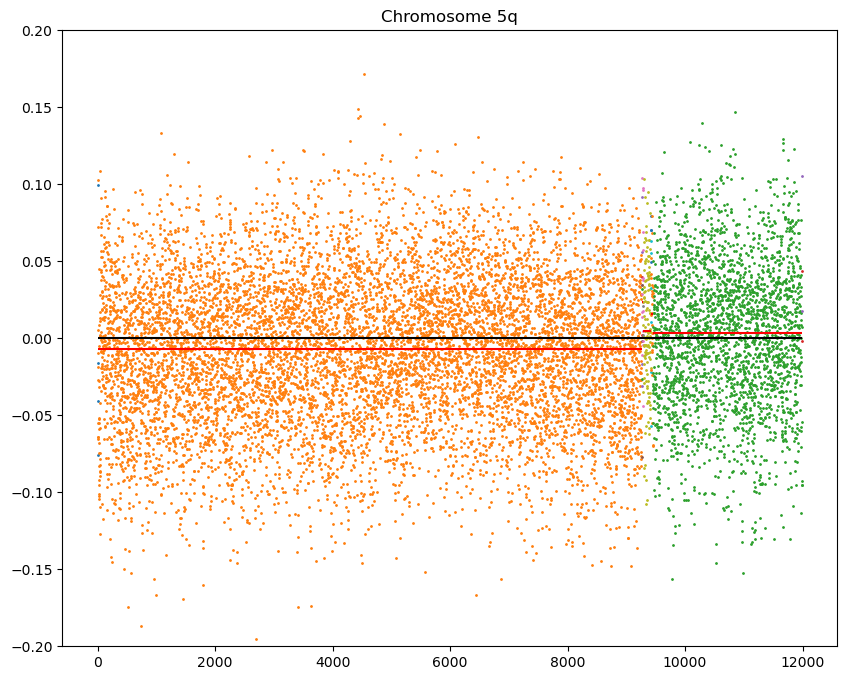

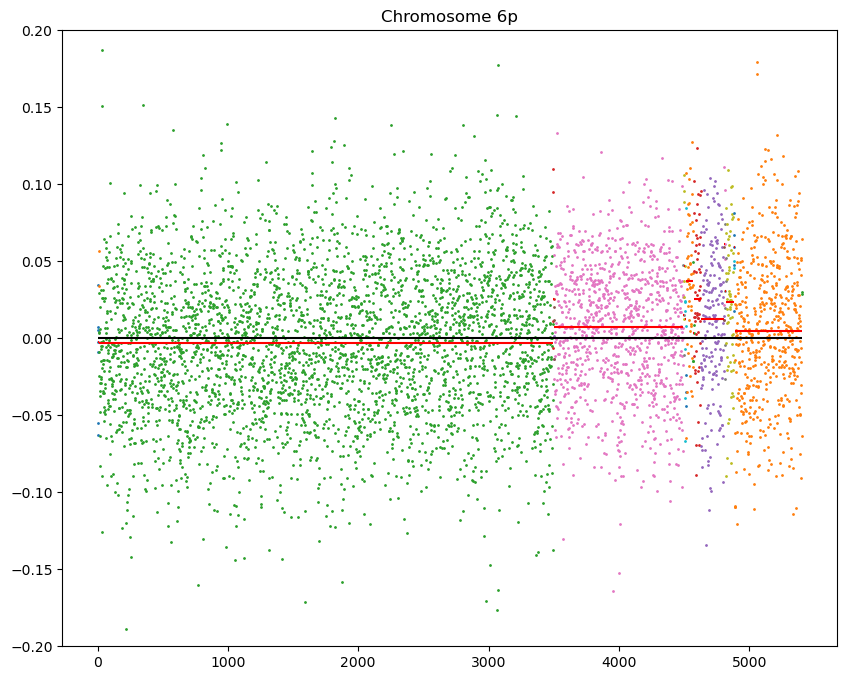

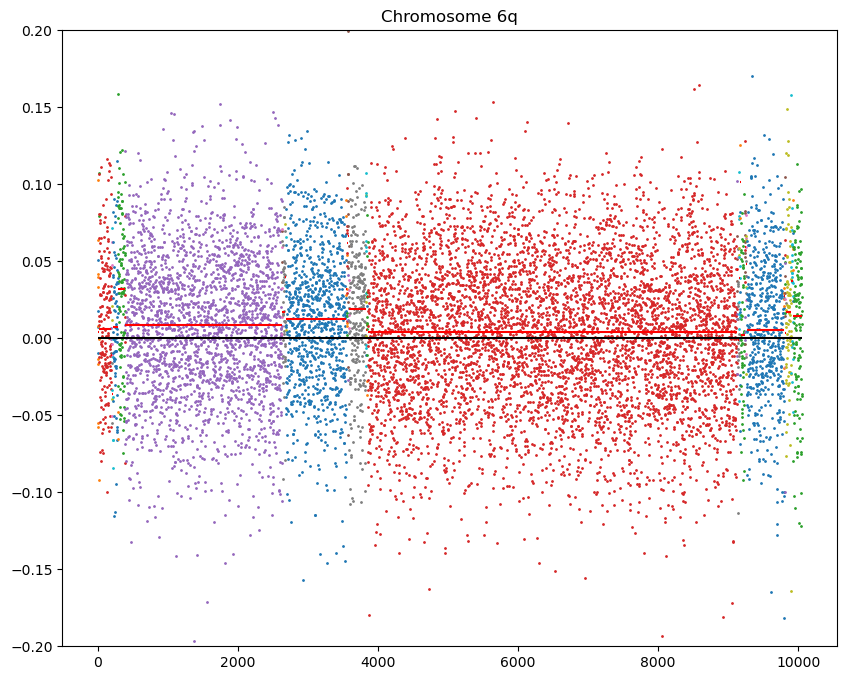

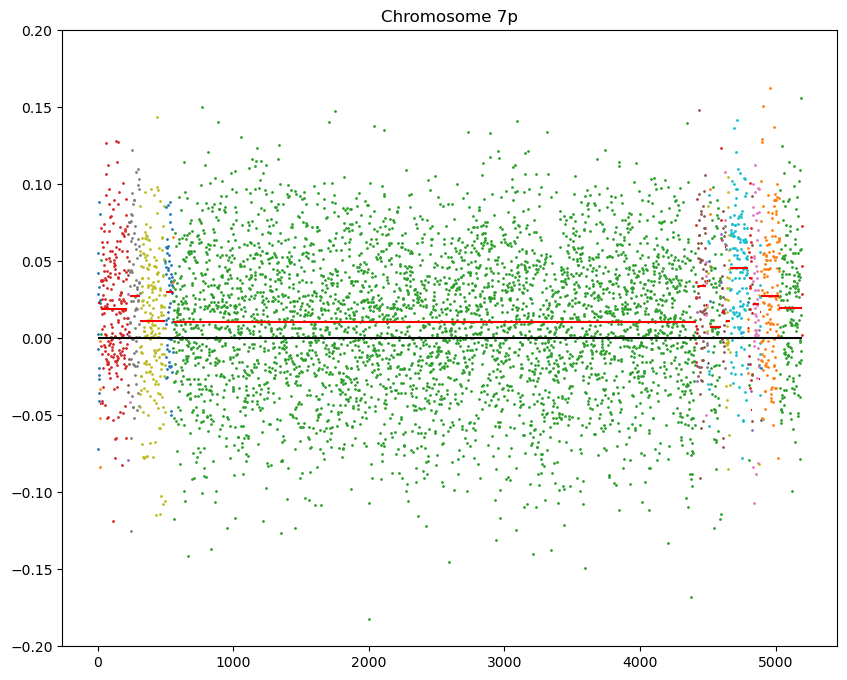

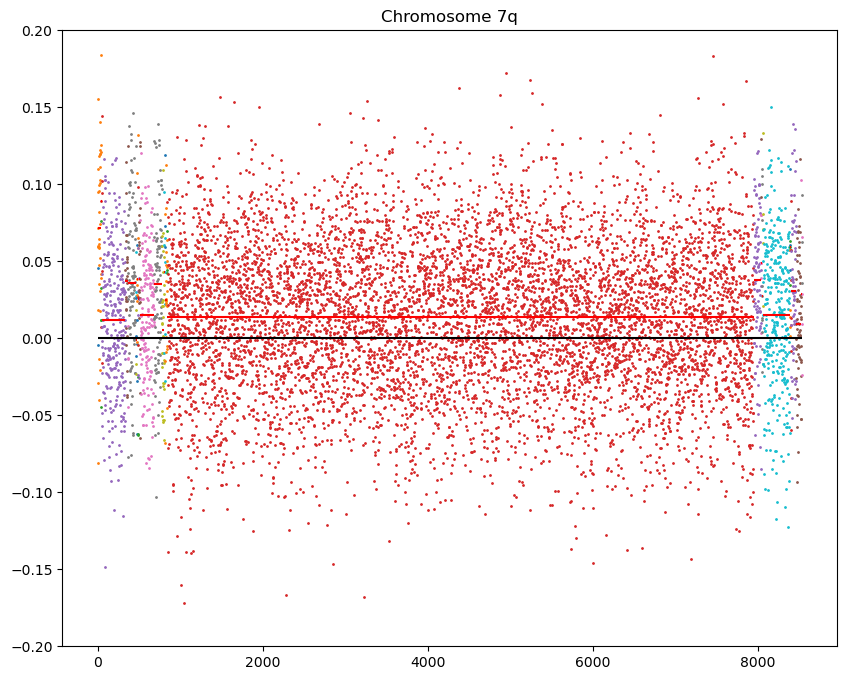

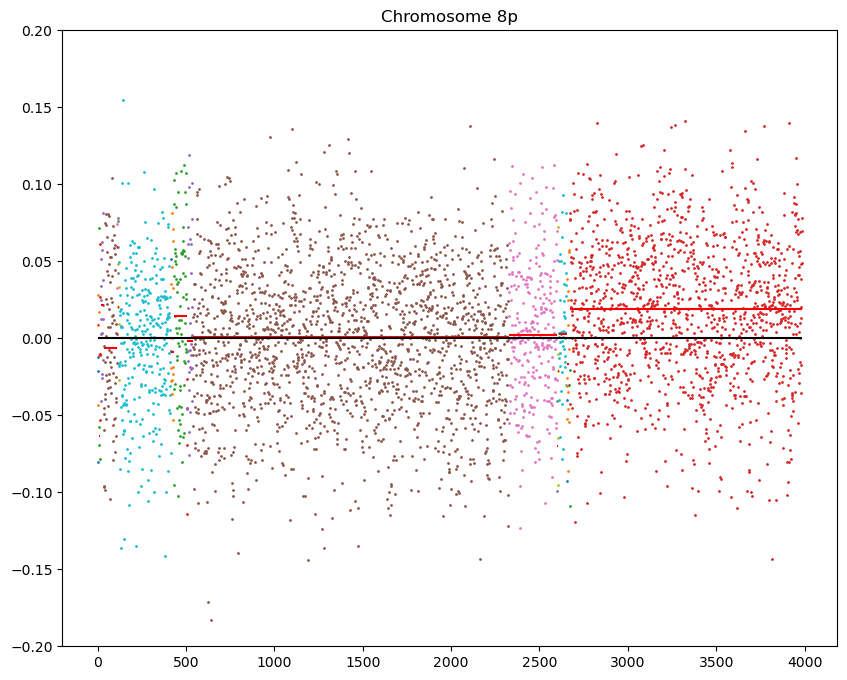

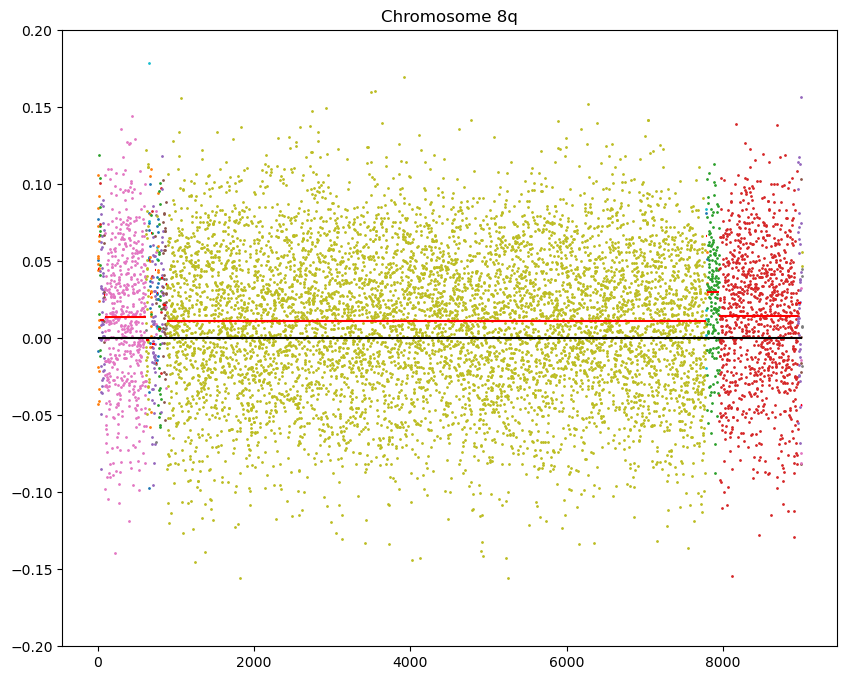

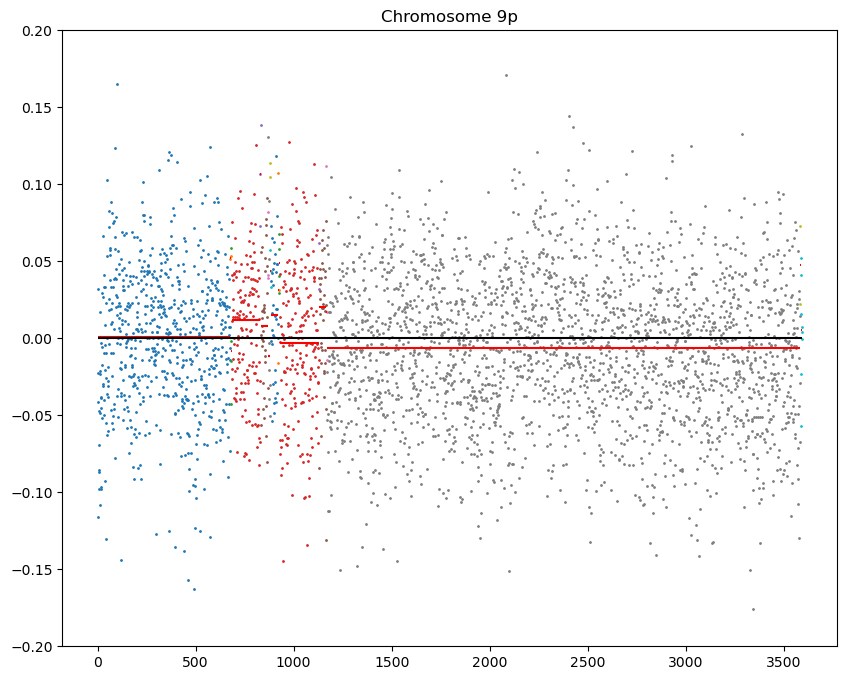

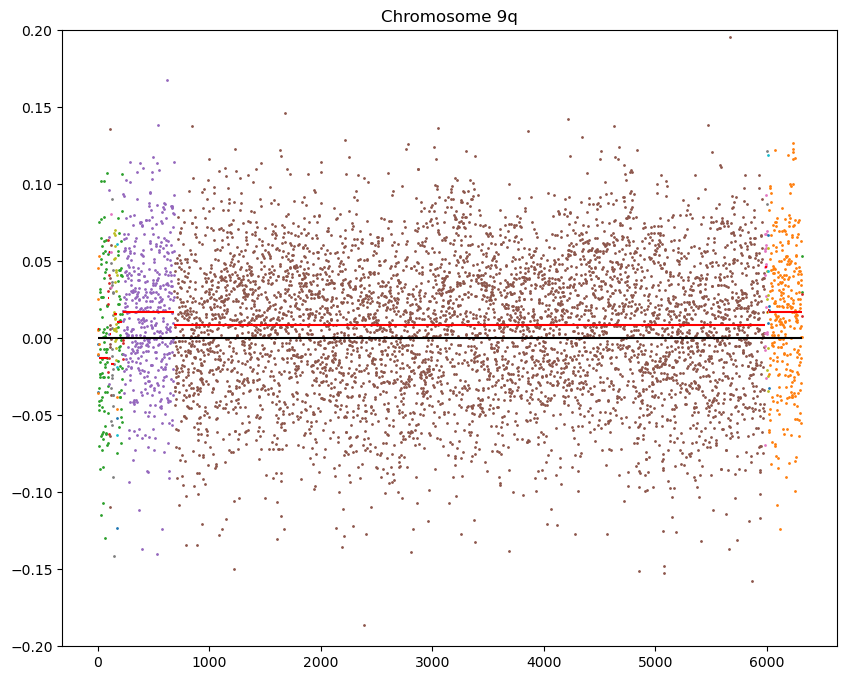

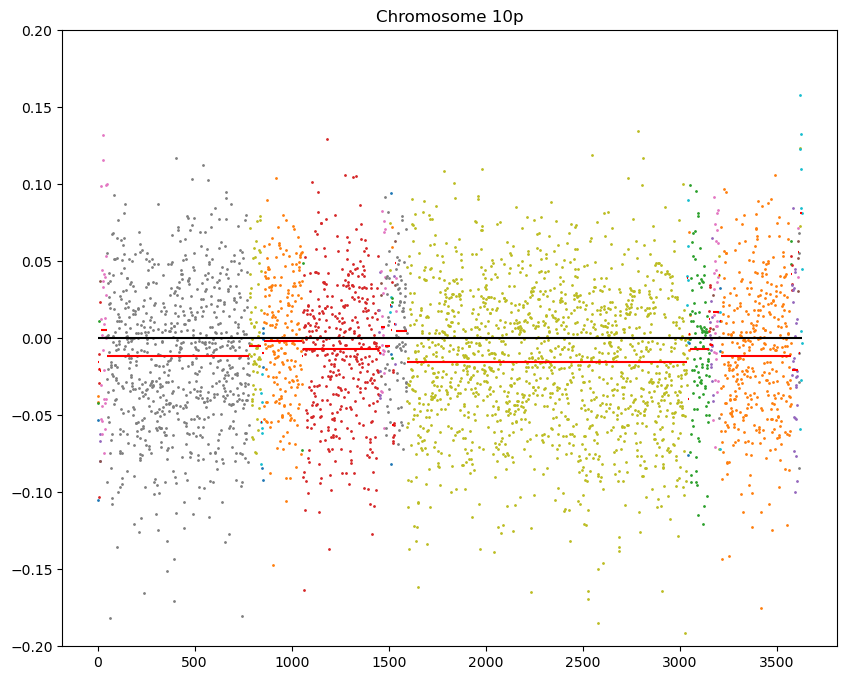

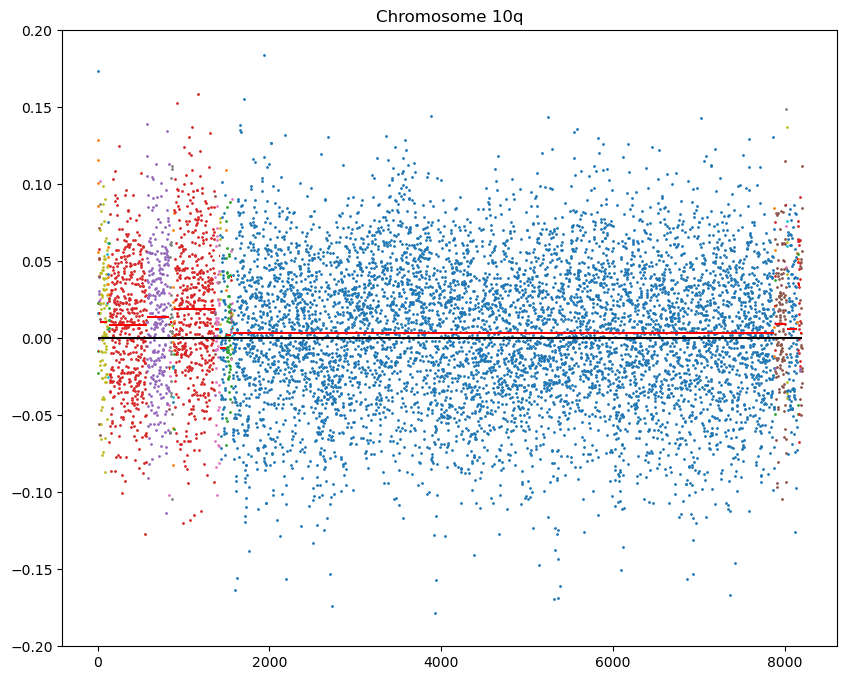

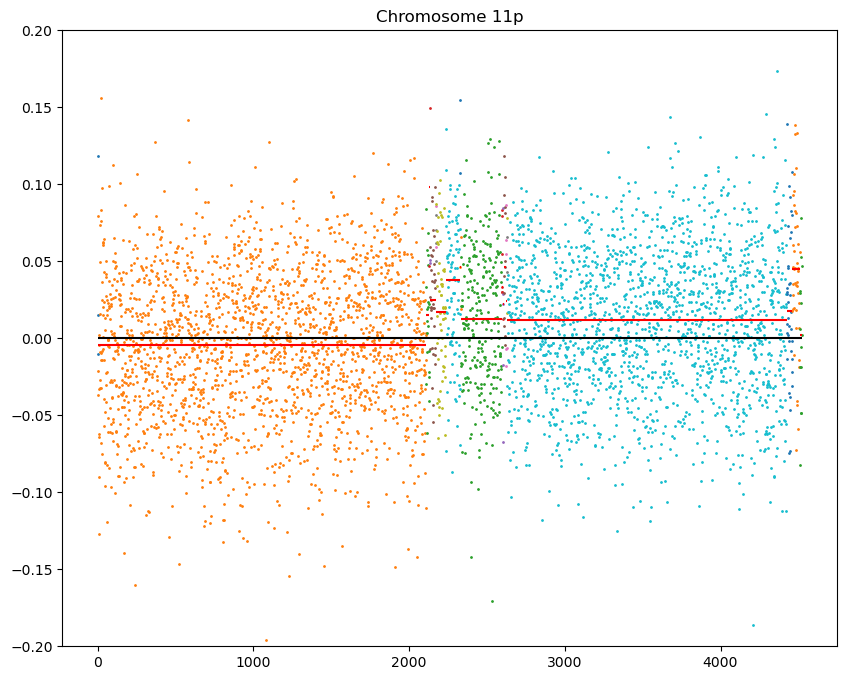

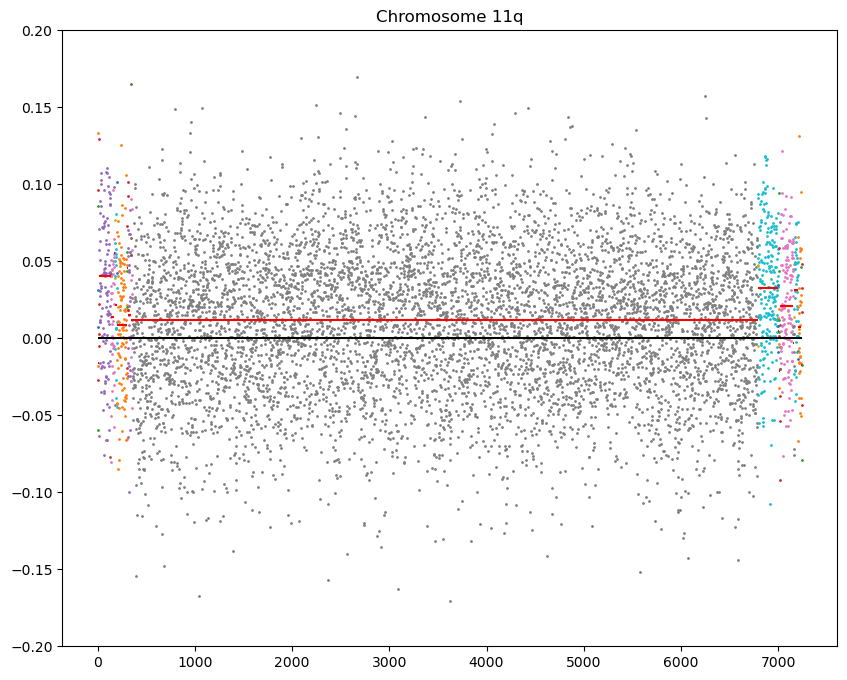

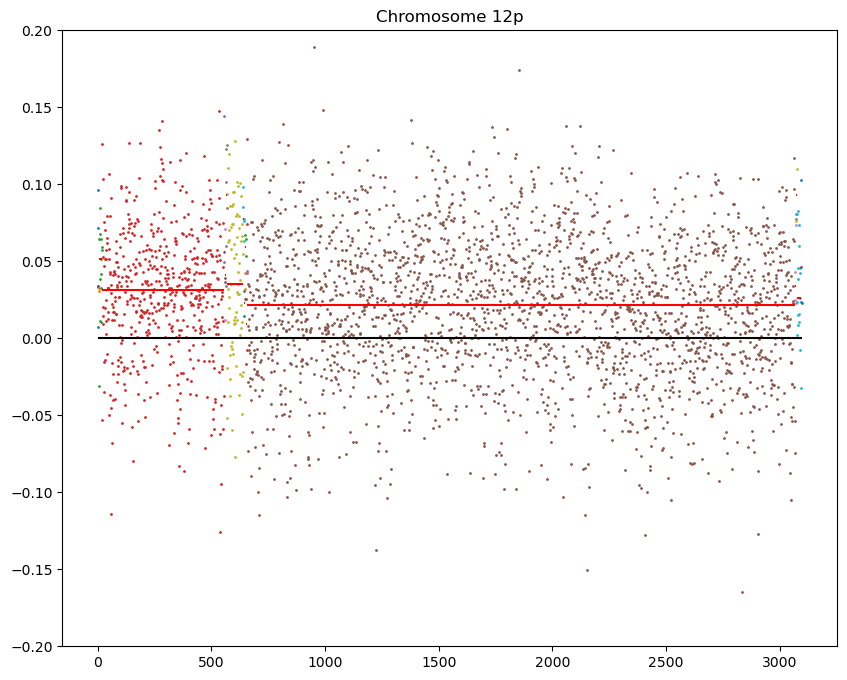

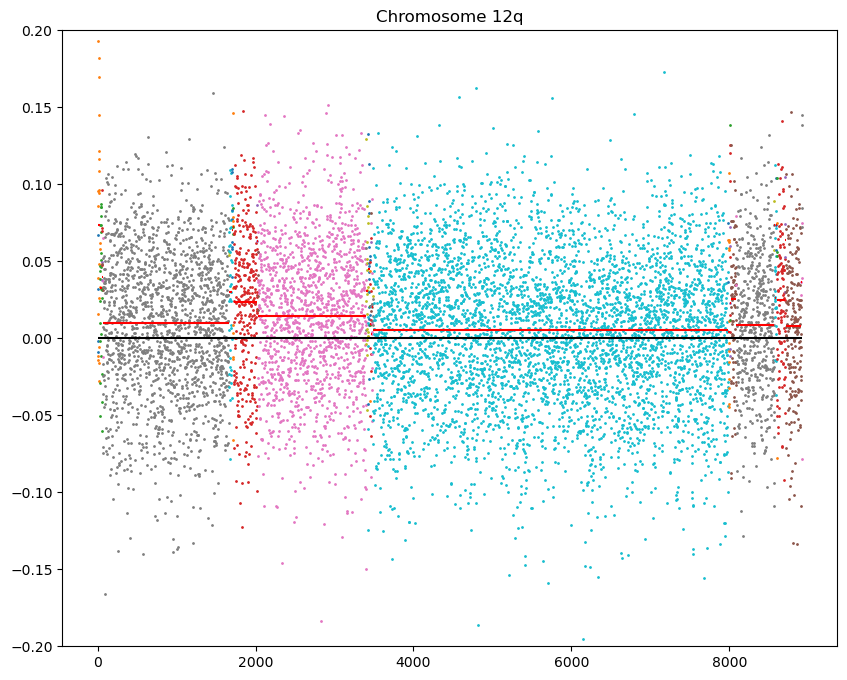

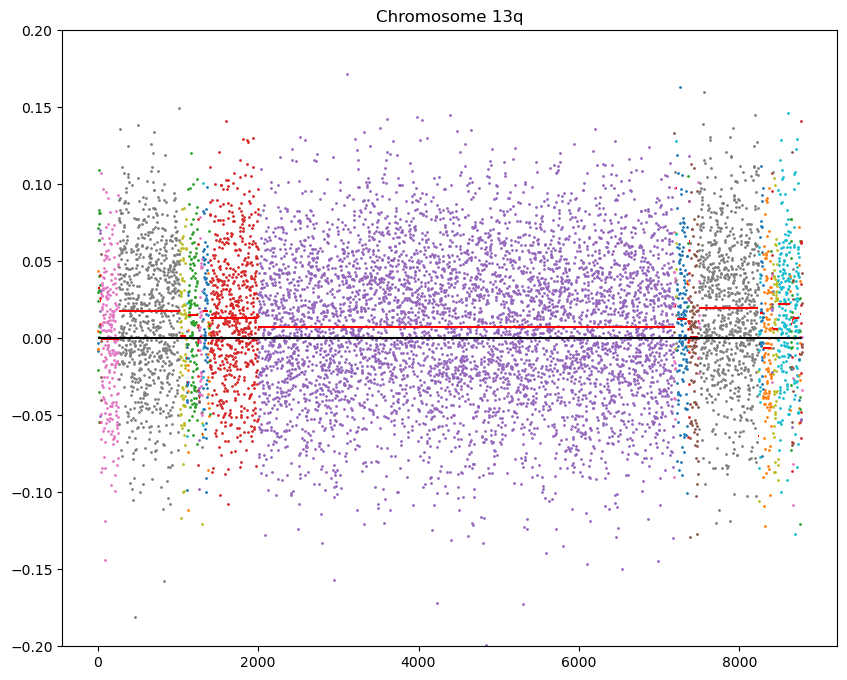

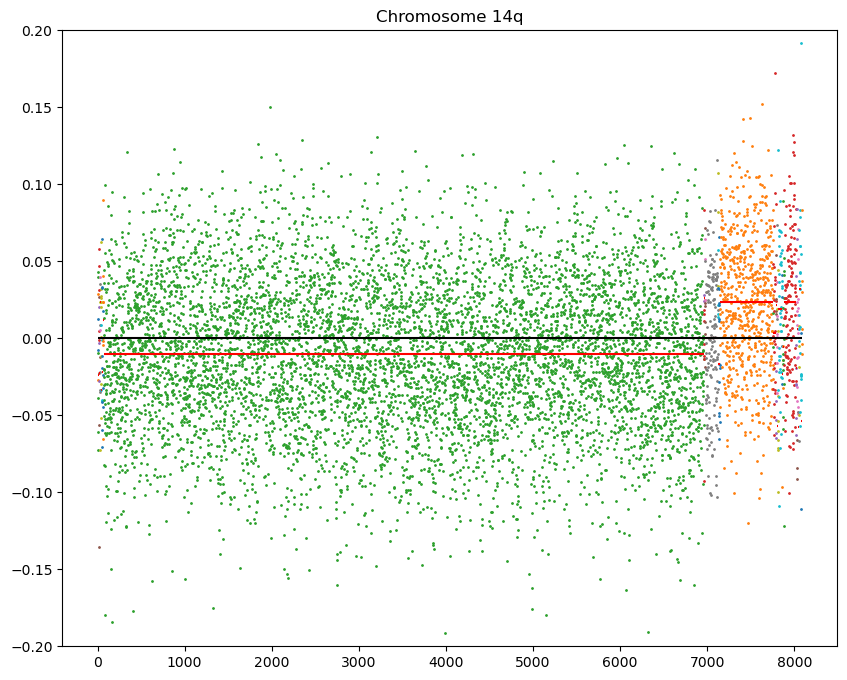

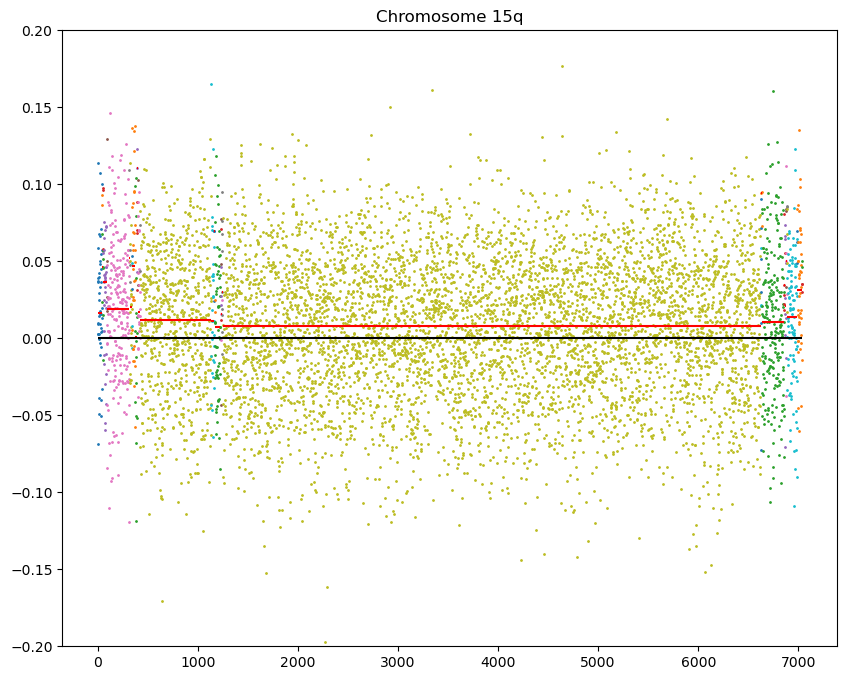

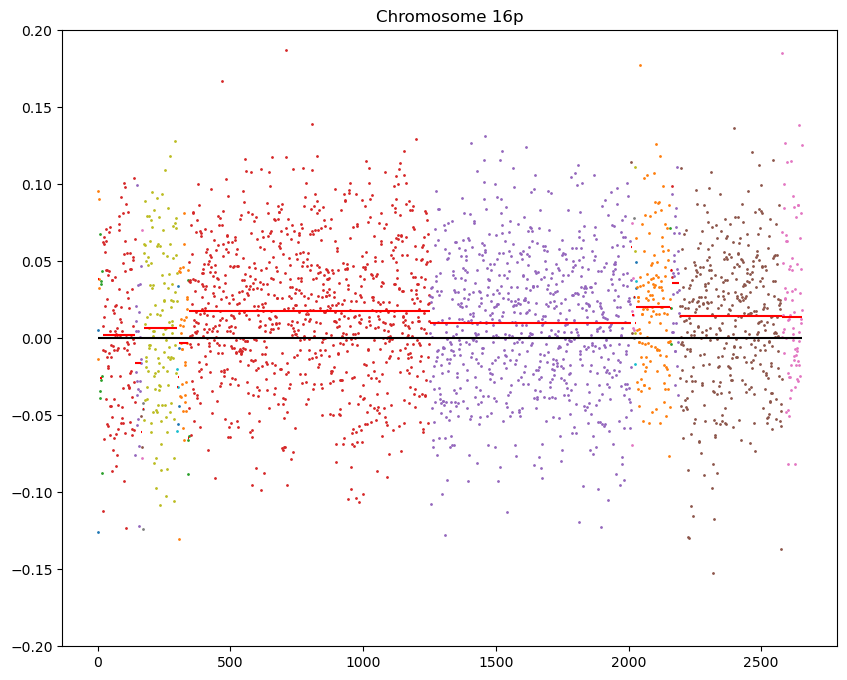

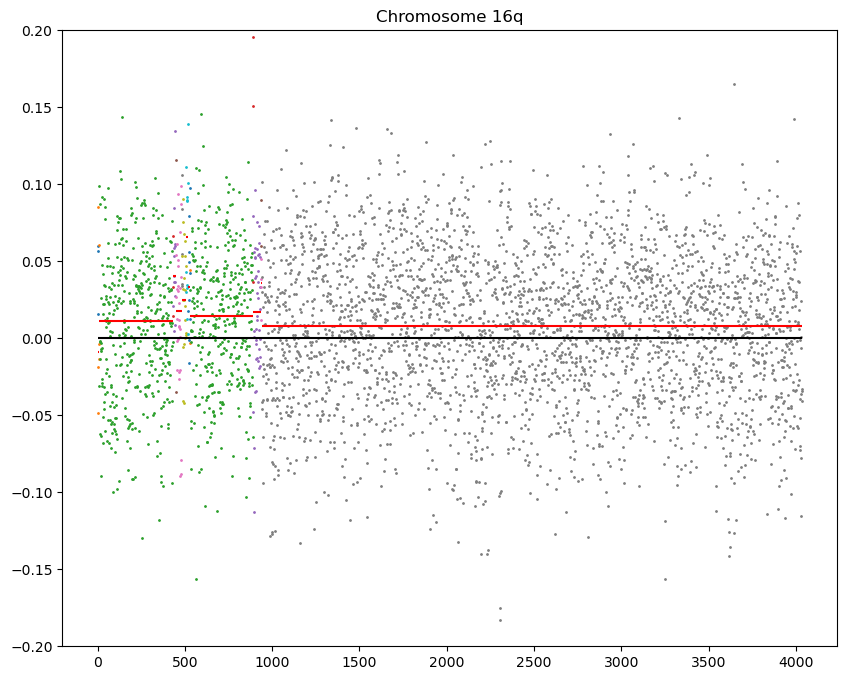

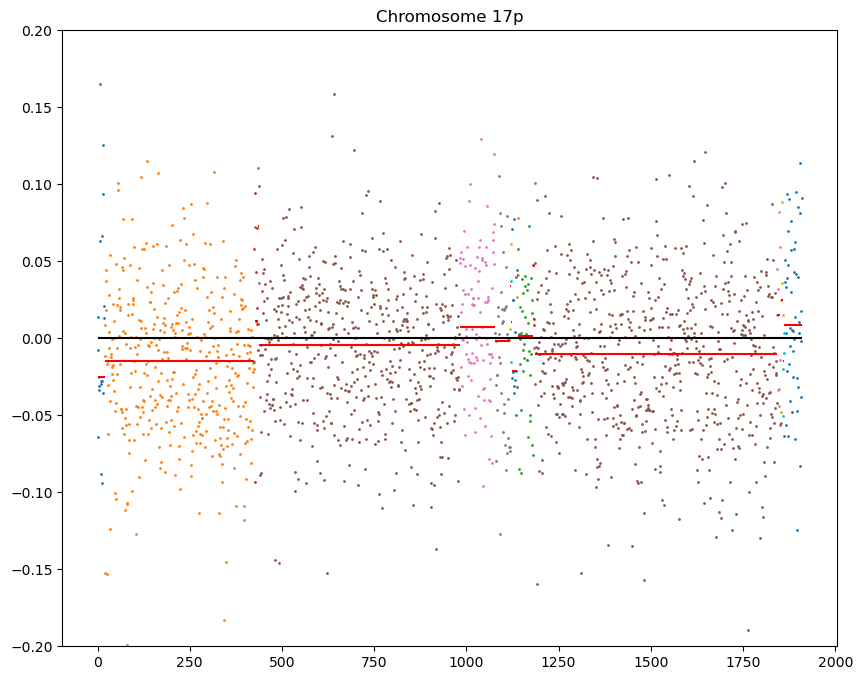

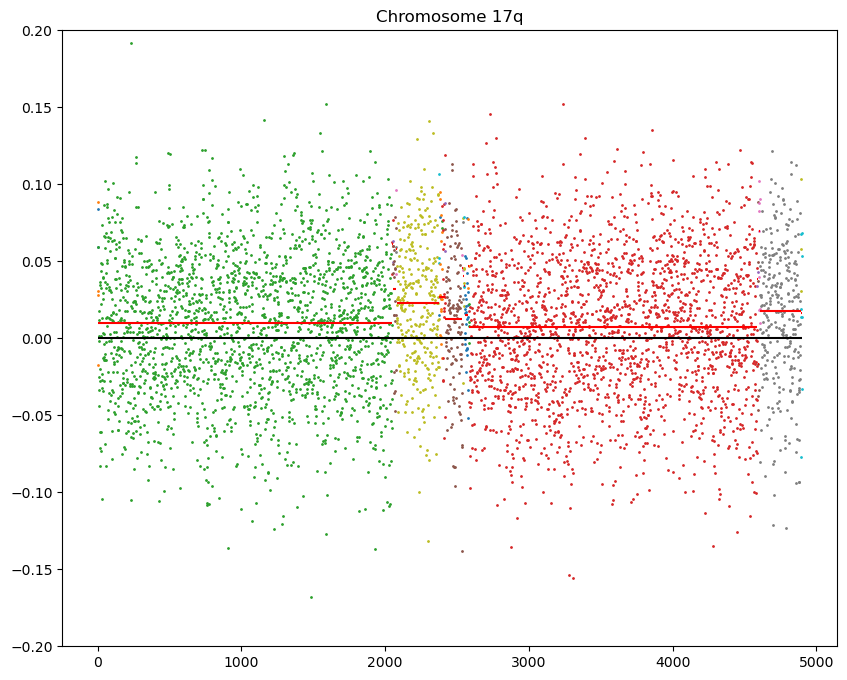

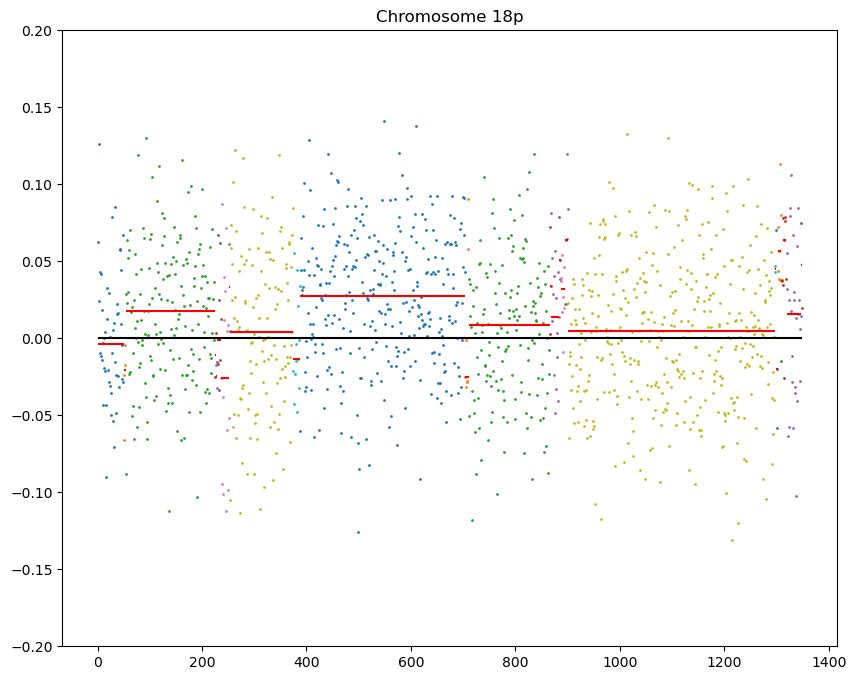

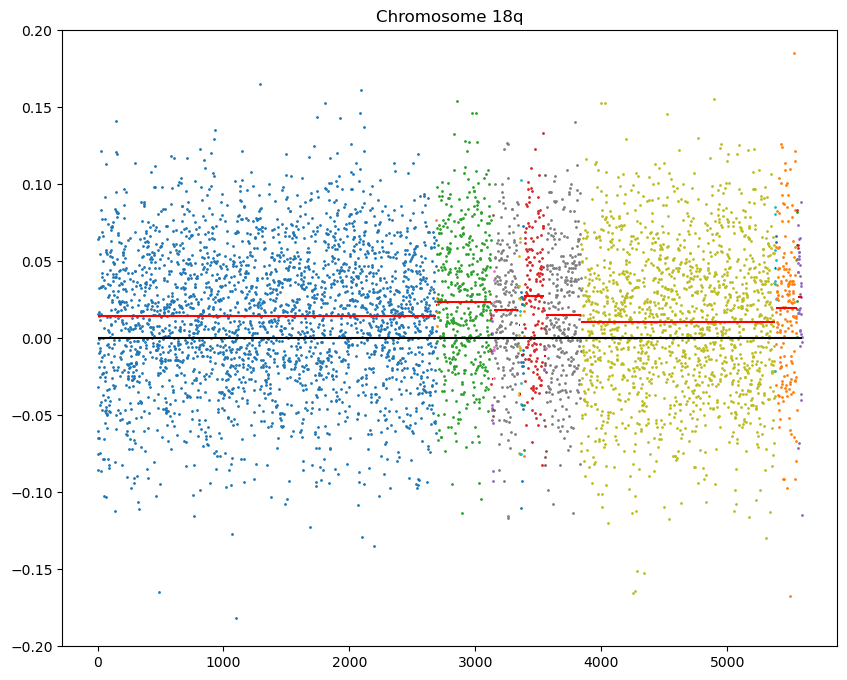

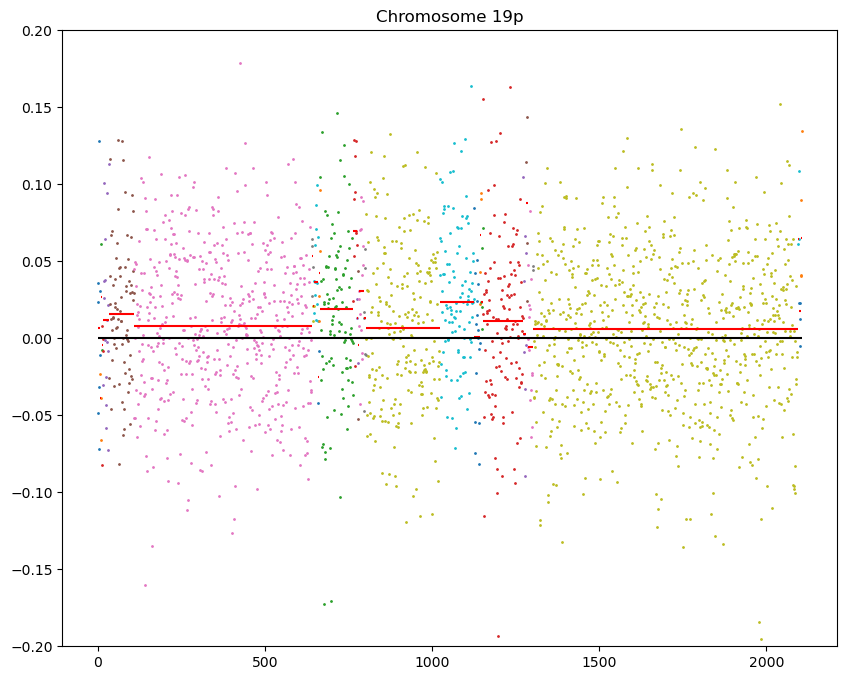

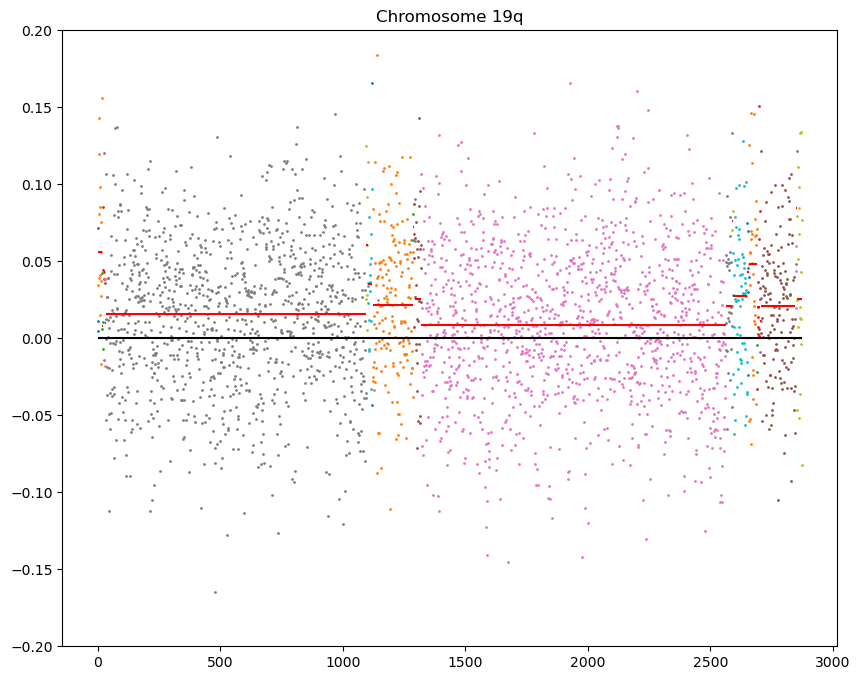

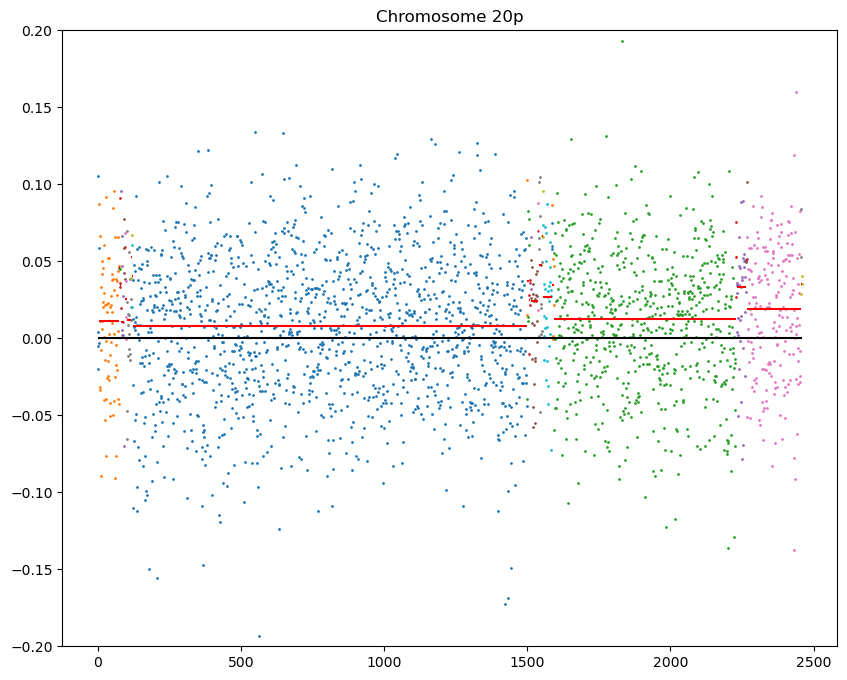

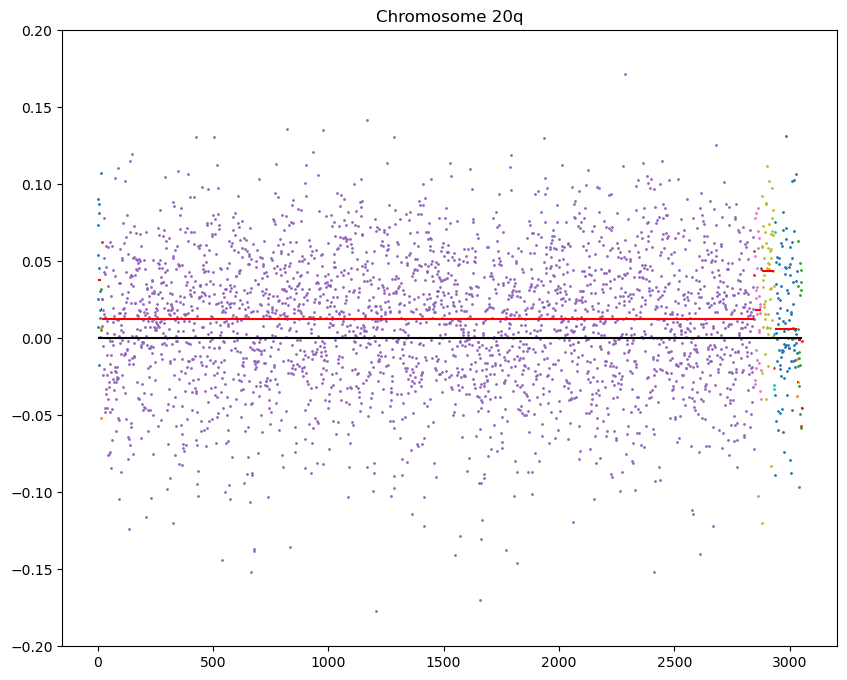

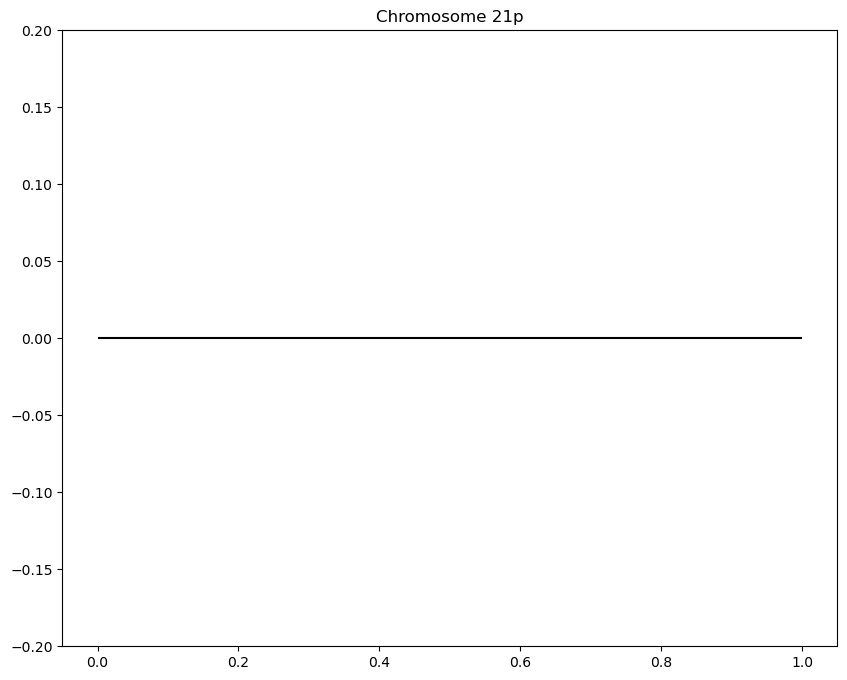

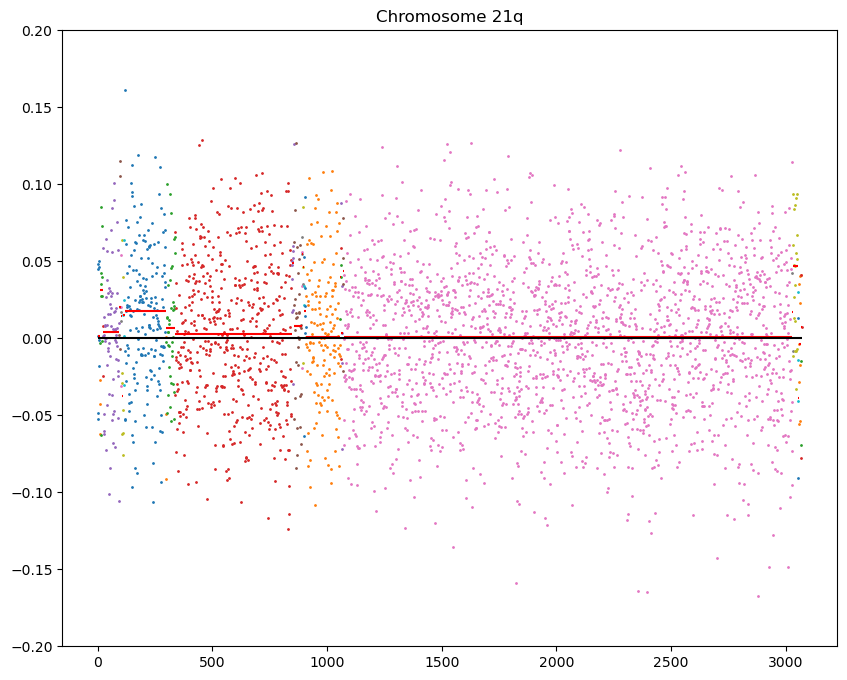

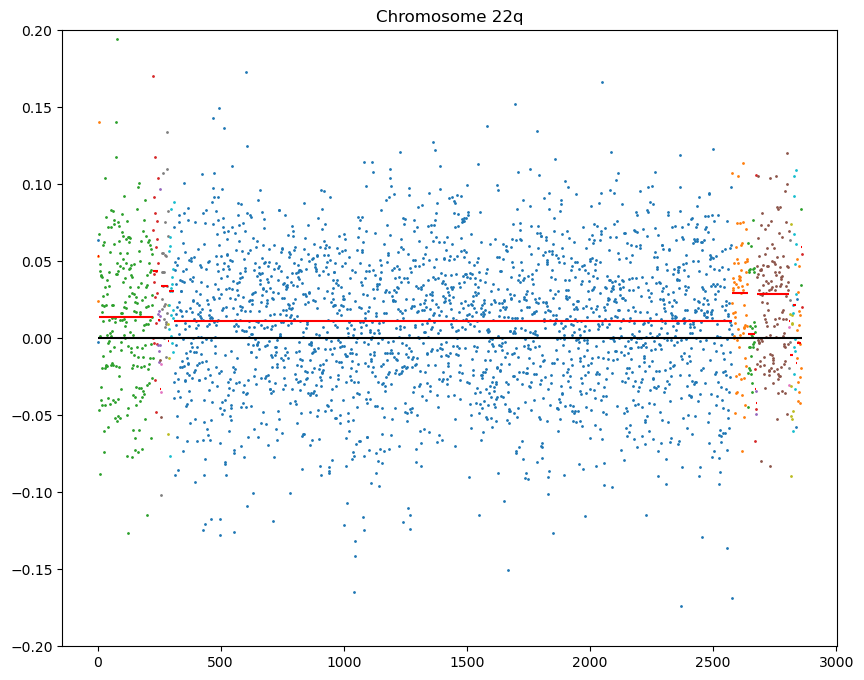

In [43]:
for arm in regions['arm'].unique():
    orig_df = regions[regions['arm'] == arm].sort_values('start')
    values = orig_df['log2_corrected'].values
    labels = np.zeros_like(values)
    segmenter = cbs.CBSSegmenter(1000, 10)
    segments = segmenter.cbs_segment(values)
    plot_segments(segments, values, arm)


0 36 0.0014670048498531102
36 180 0.032402157739433536
180 200 0.012189445553704624
200 1235 0.048635821708169595
1235 1339 0.025291587891073705
1339 1595 0.04021660944812441
1595 1931 0.025660020939841523
1931 2519 0.039224821996804604
2519 3656 0.027814997272102533
3656 3807 0.04905158983630706
3807 4058 0.02713351142621412
4058 4072 0.046261428992210266
4072 4079 0.011421843319981154
4079 4245 0.047686080362159336
4245 4414 0.02701968840809464
4414 9210 0.05893147327862479
9210 9213 -0.05381559743809233


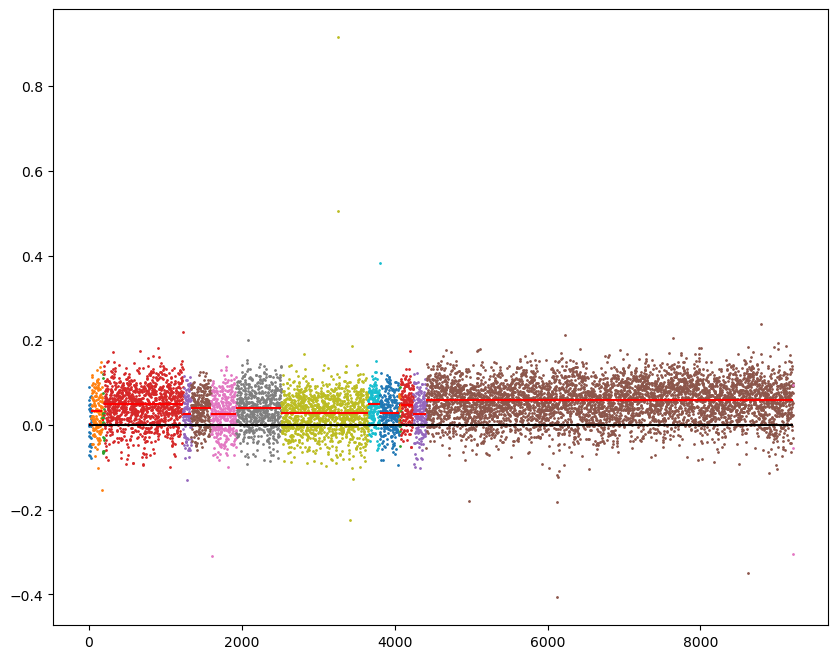

In [23]:
plot_segments(segments, values)

In [1]:
from linear_segmentation import segment
import numpy as np

# Create data
np.random.seed(10)
x = np.random.random(300000)
x[10000:20000] = x[10000:20000] + 0.1
x[25000:27000] = x[25000:27000] - 1
labels = np.repeat('a', len(x))

# Calculate segments
segments = segment(x, labels, method="online_both")
segments
segments = segment(x, labels, method="cbs")
segments


ModuleNotFoundError: No module named 'linear_segmentation'